In [20]:
from ftplib import FTP
import os
import zipfile
#import gzip
#import tarfile
from pprint import pprint
import io
import pandas
import numpy as np
import time
from IPython.display import display, HTML
import geopandas
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches


from shapely.ops import unary_union
from shapely.geometry import Point, Polygon, box
from matplotlib.patches import FancyBboxPatch, BoxStyle
#import re
from matplotlib.path import Path

# #these_states_dict = {'FL': {}, 'MD': {}}
these_states_dict = {'AK': {}, 
                     'WY': {}, 
                     'ND': {}, 
                     'SD': {}, 
                     'DE': {}, 
                     'VT': {},
#                      'HI': {},
                     'ID': {},
#                      'MT': {},
#                      'WV': {},
#                      'RI': {},
#                      'NH': {},
#                      'ME': {},
#                      'NE': {},
#                      'NM': {},
#                      'AR': {},
#                       'IA': {},
#                      'KS': {},
#                      'MS': {},
#                       'NV': {},
#                       'UT': {},
#                    'CT': {},
#                    'OK': {},
#                    'KY': {},
#                      'LA': {},
#                      'OR': {},
#                    'AL': {},
#                    'SC': {},
            }
                     

pop_total_denominator = 330759736
nDistricts = 435
target = pop_total_denominator / nDistricts


g = 0
scale = 20
map_buffer_ratio = .1
main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "
alaska_crs = "epsg:3338"
hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "

equal_area_crs = 2163  # An equal area projection: https://epsg.io/2163
desired_pct_area_overlap = 0.5

show_water = True
show_roads = False
water_area_tol = .5 * 1000 * 1000

#print('Target: each district should contain {0:,.0f} people!'.format(target))
print('ok')

ok


In [21]:
s = time.time()
script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
census_script_dir = '/home/idies/workspace/Storage/raddick/census/'
basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/'
shapefile_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/2020/'
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'

district_color_cycle = ['black', 'red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'tomato', 'silver', 'blueviolet', 'olive', 'peru', 'dodgerblue']
district_color_cycle += district_color_cycle
district_color_cycle += district_color_cycle

district_contrast_color_cycle = ['black', 'green', 'red', 'navy', 'black', 'purple', 'lime', 'black', 'red', 'red', 'black', 'red', 'black', 'black', 'white', 'yellow', 'yellow', 'yellow', 'yellow']
district_contrast_color_cycle += district_contrast_color_cycle
district_contrast_color_cycle += district_contrast_color_cycle

os.chdir(basedir)
e = time.time()
g += (e-s)
print('Now in directory: {0:}'.format(basedir))

Now in directory: /home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/


In [22]:
print('setting up infrastructure to plot roads...')
# we may derive from matplotlib.patches.BoxStyle._Base class.
# You need to override transmute method in this case.
class shield(BoxStyle._Base):
    """
    A simple box.
    """

    def __init__(self, pad=0.3):
        """
        The arguments need to be floating numbers and need to have
        default values.

         *pad*
            amount of padding
        """

        self.pad = pad
        super().__init__()

    def transmute(self, x0, y0, width, height, mutation_size):
        """
        Given the location and size of the box, return the path of
        the box around it.

         - *x0*, *y0*, *width*, *height* : location and size of the box
         - *mutation_size* : a reference scale for the mutation.

        Often, the *mutation_size* is the font size of the text.
        You don't need to worry about the rotation as it is
        automatically taken care of.
        """

        # padding
        pad = mutation_size * self.pad

        # width and height with padding added.
        width, height = width + 2.*pad, \
                        height + 2.*pad,

        # boundary of the padded box
        x0, y0 = x0-pad, y0-pad,
        x1, y1 = x0+width, y0 + height

        cp = [(0.5*(x0+x1), (y0-2.*pad)), # bottom
              (x1, y0),  # right lower-mid
              (x1+pad, (y0+y1)/2.),  # far right mid
              (x1, y1+pad),  # top right corner
              ((x0+x1)/2,y1),  # dip from top
              (x0, y1+pad),  # top left corner
              (x0-pad, (y0+y1)/2.),    # far left mid
              (x0, y0),  # left lower-mid
              ((x0+x1)/2., (y0-2.*pad)),  # return to bottom
              ((x0+x1)/2., (y0-2.*pad))]
        
        
        com = [Path.MOVETO,  # start
               Path.CURVE4, # curve to right mid
               Path.LINETO,  # line to far right mid
               Path.LINETO, # line to top right corner
               Path.CURVE3,  # line to dip
               Path.LINETO,  # line to top left corner
               Path.CURVE4,   # curve to far left mid
               Path.LINETO,   # line to left lower-mid
               Path.LINETO,
               Path.CLOSEPOLY]

        path = Path(cp, com)

        return path

BoxStyle._style_list["shield"] = shield



def parse_road_name(thename):
    try:
        annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
    except AttributeError:
        try: 
            annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
        except AttributeError:
            annotator = thisrow['FULLNAME']
    return annotator


road_label_format = { 
    'I': { 'labelsize': 16, 'thecolor': 'yellow', 'thebbox': dict(boxstyle="shield", fc='blue', ec='orange') },     
    'U': { 'labelsize': 14, 'thecolor': 'black', 'thebbox': dict(boxstyle="shield", fc='white', ec='black') },
    'S': { 'labelsize': 12, 'thecolor': 'black', 'thebbox': dict(boxstyle="square,pad=0.25", fc='white', ec='black')},
    'C': { 'labelsize': 10, 'thecolor': 'black', 'thebbox': dict(boxstyle="sawtooth,pad=0.5", fc='white') }, 
    'M': { 'labelsize': 16, 'thecolor': 'black'},
    'O': { 'labelsize': 11, 'thecolor': 'yellow' }
}
print('Done!')



setting up infrastructure to plot roads...
Done!


In [23]:
s = time.time()
# print('Getting data from FTP...')

# ftp = FTP('ftp2.census.gov')
# ftp.login()
# print(ftp.getwelcome())

# ftp.cwd('programs-surveys/decennial/2020/data/01-Redistricting_File--PL_94-171/')
# for thisdir in [x for x in ftp.nlst() if (('.pdf' not in x) and ('.doc' not in x))]:
#     print('Retrieving {0:}...'.format(thisdir))
#     zipfiles = [x for x in ftp.nlst(thisdir)]
#     for thisfile in zipfiles:
#         with io.open(thisfile.split('/')[1].lower(), 'wb') as f:
#              ftp.retrbinary('RETR {0:}'.format(thisfile), f.write)
# ftp.quit()
# print('Done')

# os.listdir()
#os.getcwd()
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Retrieved files from Census FTP!')

Retrieved files from Census FTP!


In [24]:
s = time.time()
# for thisfile in os.listdir():
#     with zipfile.ZipFile(thisfile, 'r') as z:
#         print('Extracting {0:}...'.format(thisfile))
#         z.extractall()
# for thisfile in [x for x in os.listdir() if ('zip' in x)]:
#     os.remove(thisfile)
# print('Done!')
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Unzipped files!')

Unzipped files!


# How many districts per state?

In [25]:
s = time.time()
state_seats_df = pandas.read_csv(script_dir+'state_seats.csv', index_col='state_name')

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
#state_codes_df.columns = [x.lower() for x in state_codes_df.columns]
state_codes_df = state_codes_df.set_index('STATE_NAME')

#bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# state_seats_df = state_seats_df.reset_index().merge(
#     geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']], how='left', 
#     left_on='state_name', right_on='NAME'
# )[['STATE', 'STUSAB', 'seats_old', 'seats_new']].set_index('STATE').sort_index()

# print('Found new numbers of districts for {0:,.0f} states!'.format(len(state_seats_df)))
#state_seats_df
#geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']]

state_seats_df = state_seats_df.join(state_codes_df).set_index('STATE').sort_index()
e = time.time()
g += (e-s)

print('Got old and new numbers of districts for {0:,.0f} states in {1:.1f} seconds!'.format(len(state_seats_df), e-s))

s = time.time()
for this_state in these_states_dict.keys():
    these_states_dict[this_state]['STATEFP'] = state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]    
    these_states_dict[this_state]['seats_old'] = state_seats_df[state_seats_df['STUSAB'] == this_state]['seats_old'].values[0]
    these_states_dict[this_state]['seats_new'] = state_seats_df[state_seats_df['STUSAB'] == this_state]['seats_new'].values[0]
#pprint(these_states_dict)
print('\n')

e = time.time()
g += (e-s)
print('Got old and new numbers of districts for {0:,.0f} focus states in {1:.1f} seconds!'.format(len(these_states_dict), e-s))

looking up state names from numbers...
Got old and new numbers of districts for 50 states in 0.0 seconds!


Got old and new numbers of districts for 7 focus states in 0.0 seconds!


# Read summary levels

In [26]:
s = time.time()
print('setting up summary levels...')
sumlevel_df = pandas.read_excel(script_dir+'sumlevel.xlsx')
sumlevel_df = sumlevel_df.rename(columns={'sumlevel': 'SUMLEV'})
sumlevel_df.index.name = 'rownumber'
#sumlevel_df = sumlevel_df.set_index('SUMLEV')
e = time.time()
g += (e-s)
print('Read descriptions for {0:,.0f} summary levels in {1:.1f} seconds!'.format(len(sumlevel_df), e-s))
#sumlevel_df


setting up summary levels...
Read descriptions for 85 summary levels in 0.0 seconds!


In [ ]:
# print('getting states...')
# state_all_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_state.shp')
# state_all_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(state_all_gdf['STATEFP'], errors='coerce')
# #state_gdf = state_gdf[state_gdf['STATEFP'].isin(state_numbers_include_list)]
# #state_all_gdf[~state_all_gdf['STUSPS'].isin(['DC', 'PR', 'MP', 'VI', 'AS', 'GU'])][['STATEFP', 'STUSPS', 'NAME']].sort_values(by='STUSPS')
# state_all_gdf.columns


# Read redistricting geo data

In [27]:
s = time.time()
print('reading redistricting geography data for all states...')
geofiles = []

allgeofiles = [x for x in os.listdir() if (('geo' in x) and (x[-3:] == '.pl') and (x[:2] not in ['dc', 'pr', 'mp', 'vi', 'as', 'gu']))]
for this_focus_state in list(these_states_dict.keys()):
    geofiles += [x for x in allgeofiles if x[0:2] == this_focus_state.lower()]
    #geofiles.append([x for x in geofiles if x[0:2] == this_focus_state.lower()])

geo_df = pandas.DataFrame()

for thisfile in geofiles:
    print('\treading {0:}...'.format(thisfile))
    geo_df_i = pandas.read_csv(thisfile, sep='|', header=None, low_memory=False, encoding='ISO-8859-1')#, encoding='utf-8')
    geo_df = pandas.concat((geo_df, geo_df_i), axis=0)
    
print('renaming columns...')
column_names = []
column_names += ['FILEID', 'STUSAB', 'SUMLEV', 'GEOVAR', 'GEOCOMP', 'CHARITER', 'CIFSN', 'LOGRECNO', 'GEOID']
column_names += ['GEOCODE', 'REGION', 'DIVISION', 'STATE', 'STATENS', 'COUNTY', 'COUNTYCC', 'COUNTYNS']
column_names += ['COUSUB', 'COUSUBCC', 'COUSUBNS']
column_names += ['SUBMCD', 'SUBMDCC', 'SUBMCDNS', 'ESTATE', 'ESTATECC', 'ESTATENS']
column_names += ['CONCIT', 'CONCITCC', 'CONCITNS', 'PLACE','PLACECC', 'PLACENS']
column_names += ['TRACT', 'BLKGRP', 'BLOCK']
column_names += ['AIANHH', 'AIANHHLI', 'AIANHHFP', 'AIANHHCC', 'AIANHHNS', 'AITS', 'AITSFP', 'AITSCC', 'AITSNS']
column_names += ['TTRACT', 'TBLKGRP', 'ANRC', 'ANRCCC', 'ARNCNS']
column_names += ['CBSA', 'MEMI', 'CSA', 'METDIV']
column_names += ['NECTA', 'NMEMI', 'CNECTA', 'NECTADIV']
column_names += ['CBSAPCI', 'NECTAPCI', 'UA', 'UATYPE', 'UR']
column_names += ['CD116', 'CD118', 'CD119', 'CD120', 'CD121']
column_names += ['SLDU18', 'SLDU22', 'SLDU24', 'SLDU26', 'SLDU28']
column_names += ['SLDL18', 'SLDL22', 'SLDL24', 'SLDL26', 'SLDL28']
column_names += ['VTD', 'VTDI', 'ZCTA', 'SDELM', 'SDSEC', 'SDUNI', 'PUMA']
column_names += ['AREALAND', 'AREAWATER', 'BASENAME', 'NAME', 'FUNCSTAT', 'GCUNI']
column_names += ['POP100', 'HU100']
column_names += ['INTPTLAT', 'INTPTLON', 'LSADC', 'PARTFLAG', 'UGA']

# for i in range(0, len(column_names)):    
#     if (np.isnan(pandas.to_numeric(column_names[i], errors='coerce'))):
#         geo_df = geo_df.rename(columns = {i: column_names[i]})
#     else:
#         geo_df = geo_df.rename(columns = {i: int(column_names[i])})

geo_df.columns = column_names

print('\tTotal columns: {0:.0f}'.format(len(geo_df.columns)))
print('\tNamed columns: {0:.0f}'.format(len(column_names)))

geo_df = geo_df.set_index('GEOID')


# print('finding stuff...')
# mycol = 'UGA'
# showcolumns = []
# showcolumns += ['SUMLEV', mycol]
#geo_df[geo_df[mycol].notnull()][showcolumns]
#print('done')

# geo_df.merge(sumlevel_df, how='left', on='SUMLEV')
# geo_df.set_index('SUMLEV')
# print('adding summary level descriptions...')
# geo_df = geo_df.reset_index().merge(sumlevel_df, how='left', on='SUMLEV').set_index('GEOID')
# geo_df = geo_df.rename(columns={'description': 'sumlev_description'})

#geo_df
e = time.time()
g += (e-s)
print('\n')
print('Read {0:,.0f} geographies in {1:.0f} minutes {2:.0f} seconds!'.format(len(geo_df), np.floor((e-s)/60), (e-s)%60))


reading redistricting geography data for all states...
	reading akgeo2020.pl...
	reading wygeo2020.pl...
	reading ndgeo2020.pl...
	reading sdgeo2020.pl...
	reading degeo2020.pl...
	reading vtgeo2020.pl...
	reading idgeo2020.pl...
renaming columns...
	Total columns: 97
	Named columns: 97


Read 509,057 geographies in 0 minutes 26 seconds!


In [14]:
s = time.time()
print('counting by summary level...')
count_df = pandas.DataFrame(data=None, columns=['sumlev_description', 'count', 'pop'], index=sumlevel_df['SUMLEV'].tolist())
count_df.index.name = 'SUMLEV'
count_df.loc[:, 'sumlev_description'] = sumlevel_df.set_index('SUMLEV')['description']
count_df.loc[:, 'count'] = geo_df.groupby('SUMLEV').size()
count_df.loc[:, 'pop'] = geo_df.groupby('SUMLEV')['POP100'].sum()
#count_df
nan_levels = count_df[count_df['count'].isnull()].index.tolist()

htmlstr = ''
htmlstr += '<table>'
htmlstr += '<tr>'
htmlstr += '<th>SUMLEVEL</th>'
for thiscol in count_df.columns.tolist():    
    htmlstr += '<th>{0:}</th>'.format(thiscol)
htmlstr += '</tr>'

for sumlev, thisrow in count_df.iterrows():
    #if ('remainder' not in thisrow['sumlev_description'].lower()):
    if (sumlev not in nan_levels):
        htmlstr += '<tr>'    
        htmlstr += '<td>{0:3d}</td><td>{1:}</td><td>{2:,.0f}</td><td>{3:,.0f}</td>'.format(sumlev, thisrow['sumlev_description'], thisrow['count'], thisrow['pop'])
        htmlstr += '</tr>'
htmlstr += '</table>'

# print('No data for these columns: {0:}'.format(nan_levels))
# display(HTML(htmlstr))

e = time.time()
g += (e-s)
print('\n')
print('Documented {0:,.0f} geographies in {1:.1f} seconds!'.format(len(count_df), e-s))



counting by summary level...


Documented 85 geographies in 0.1 seconds!


In [28]:
print('getting tract data...')
s = time.time()
tract_df = geo_df[geo_df['SUMLEV'] == 140]
tract_df = tract_df.assign(census_tract = tract_df['TRACT'].apply(lambda x: x/100))
#tract_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
tract_df = tract_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
county_names_df = county_names_df.reset_index(drop=True)
tract_df = tract_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

print('adding empty column for new districts...')
tract_df = tract_df.assign(new_district = np.nan)

print('adding shapefiles...')
gdf = geopandas.GeoDataFrame()
for this_state in tract_df['STATE'].drop_duplicates().tolist():
    print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state]['STUSAB'].values[0]))
    gdf_i = geopandas.read_file(shapefile_basedir+'TRACT/tl_2020_{0:02d}_tract.shp'.format(this_state))
    #print('\t\t{0:} CRS = {1:}'.format(this_state, gdf_i.crs))
    gdf = pandas.concat((gdf, gdf_i), axis=0)
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1400000US'+x)
gdf = gdf.set_index('GEOID')
tract_gdf = geopandas.GeoDataFrame(data=tract_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')


#state_codes_df
#tract_df = tract_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} tracts to shapefiles in {1:.1f} seconds!'.format(len(tract_gdf), e-s))



getting tract data...
looking up state names from numbers...
looking up county names from numbers...
adding empty column for new districts...
adding shapefiles...
	getting shapefiles for AK...
	getting shapefiles for WY...
	getting shapefiles for ND...
	getting shapefiles for SD...
	getting shapefiles for DE...
	getting shapefiles for VT...
	getting shapefiles for ID...


Joined 1,718 tracts to shapefiles in 14.2 seconds!


In [ ]:
# print('getting block group data...')
# s = time.time()
# bg_df = geo_df[geo_df['SUMLEV'] == 150]
# bg_df = bg_df.assign(census_tract = bg_df['TRACT'].apply(lambda x: x/100))
# #bg_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

# print('looking up state names from numbers...')
# state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
# bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


# print('looking up county names from numbers...')
# county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
# county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
# county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
# county_names_df = county_names_df.reset_index(drop=True)
# bg_df = bg_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

# print('adding empty column for new districts...')
# bg_df = bg_df.assign(new_district = np.nan)

# print('adding shapefiles...')
# gdf = geopandas.GeoDataFrame()
# for this_state in bg_df['STATE'].drop_duplicates().tolist():
#     print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state]['STUSAB'].values[0]))
#     gdf_i = geopandas.read_file(shapefile_basedir+'BG/tl_2020_{0:02d}_bg.shp'.format(this_state))
#     print('\t\t{0:} CRS = {1:}'.format(this_state, gdf_i.crs))
#     gdf = pandas.concat((gdf, gdf_i), axis=0)
# gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1500000US'+x)
# gdf = gdf.set_index('GEOID')
# bg_gdf = geopandas.GeoDataFrame(data=bg_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')




# #state_codes_df
# #bg_df = bg_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# e = time.time()
# g += (e-s)
# print('\n')
# print('Joined {0:,.0f} block groups to shapefiles in {1:.1f} seconds!'.format(len(bg_gdf), e-s))




In [16]:
s = time.time()
print('Getting current Congressional District data...')
cd_df = geo_df[geo_df['SUMLEV'] == 500]
cd_df = cd_df[cd_df['CD116'] != 'ZZ']
cd_df.loc[:, 'CD116'] = pandas.to_numeric(cd_df['CD116'], errors='coerce')
cd_df.loc[cd_df['CD116'] == 0, 'CD116'] = 1

print('adding shapefiles...')
gdf = geopandas.read_file(shapefile_basedir+'CD/tl_2020_us_cd116.shp')
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '5001600US'+x)
gdf = gdf.set_index('GEOID')

cd_gdf = geopandas.GeoDataFrame(data=cd_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')
#cd_gdf

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} congressional districts to shapefiles in {1:.1f} seconds!'.format(len(cd_gdf), e-s))
#cd_gdf[['STATE', 'STUSAB']].drop_duplicates()
#cd_gdf.plot()
# print(cd_gdf.groupby('CD116')['POP100'].sum())
# print('\n')
# print(cd_gdf.groupby('STUSAB')['POP100'].sum())
# print('\n')
# print('{0:,.0f}'.format(cd_gdf['POP100'].sum()))


Getting current Congressional District data...
adding shapefiles...


Joined 2 congressional districts to shapefiles in 3.2 seconds!


In [17]:
s = time.time()
this_state = 'ID'

state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

print('getting states...')
state_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_state.shp')
state_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(state_gdf['INTPTLON'])
state_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(state_gdf['INTPTLAT'])
state_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(state_gdf['STATEFP'], errors='coerce')
#state_gdf = state_gdf[state_gdf['STATEFP'].isin(state_numbers_include_list)]
state_gdf = state_gdf.set_index('GEOID')

print('getting counties...')
county_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_county.shp')
county_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(county_gdf['STATEFP'], errors='coerce')
county_gdf.loc[:, 'COUNTYNS'] = pandas.to_numeric(county_gdf['COUNTYNS'], errors='coerce')
county_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(county_gdf['INTPTLON'])
county_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(county_gdf['INTPTLAT'])
#county_gdf = county_gdf[county_gdf['STATEFP'].isin(state_numbers_include_list)]
county_gdf = county_gdf.set_index('GEOID')

e = time.time()
g += (e-s)
print('Got {0:,.0f} states and {1:,.0f} counties in {2:.1f} seconds!'.format(len(state_gdf), len(county_gdf), e-s))
print('\n')


if (show_water):
    print('getting water areas...')

    waterfiles = [shapefile_basedir+'AREAWATER/'+x for x in os.listdir(shapefile_basedir+'AREAWATER/') if ((x[-4:] == '.shp') )]
    state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
    state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

    waterfiles = [x for x in waterfiles if x[89:91] in state_numbers_include_list]

    water_gdf = geopandas.GeoDataFrame()

    for i in range(0, len(waterfiles)):
        if (np.mod(i, 10) == 0):
            print('\treading water file {0:,.0f} of {1:,.0f}...'.format(i, len(waterfiles)))
        water_gdf_i = geopandas.read_file(waterfiles[i])
        water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf_i = water_gdf_i.assign(STUSAB = state_codes_df[state_codes_df['STATE'] == int(waterfiles[i][89:91])]['STUSAB'].values[0])
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0)
    water_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(water_gdf['INTPTLON'], errors='coerce')
    water_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(water_gdf['INTPTLAT'], errors='coerce')
    water_gdf = water_gdf.set_index('HYDROID')
    
    e = time.time()
    g += (e-s)

    print('Got {0:,.0f} water areas in {1:.0f} minutes {2:.1f} seconds!'.format(len(water_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


s = time.time()
print('getting CBSAs (metro areas)...')
cbsa_gdf = geopandas.read_file(shapefile_basedir+'CBSA/tl_2020_us_cbsa.shp')
cbsa_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(cbsa_gdf['INTPTLON'])
cbsa_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(cbsa_gdf['INTPTLAT'])
cbsa_gdf.loc[:, 'MEMI'] = pandas.to_numeric(cbsa_gdf['MEMI'])
cbsa_gdf = cbsa_gdf.set_index('GEOID')

print('\tFinding populations of CBSAs...')
cbsa_gdf = cbsa_gdf.assign(POP100 = np.nan)
for ix, thisrow in cbsa_gdf.iterrows():
    cbsa_gdf.loc[ix, 'POP100'] = tract_gdf[(tract_gdf['COUNTYNS'].isin(county_gdf[county_gdf.geometry.within(thisrow.geometry)]['COUNTYNS'].tolist()))]['POP100'].sum()
#     if (this_state in thisrow['NAME']):
#         print('\t\t{0:} (n = {1:,.0f})...'.format(thisrow['NAME'], cbsa_gdf.loc[ix]['POP100']))
cbsa_gdf.loc[cbsa_gdf[cbsa_gdf['POP100'] == 0].index.tolist(), 'POP100'] = np.nan

e = time.time()
g += (e-s)
print('Got {0:,.0f} CBSAs in {1:.1f} seconds!'.format(len(cbsa_gdf), e-s))
print('\n')
s = time.time()
print('getting places...')
placefiles = [shapefile_basedir+'PLACE/'+x for x in os.listdir(shapefile_basedir+'PLACE/') if ((x[-4:] == '.shp'))]
placefiles = [x for x in placefiles if x[85:87] in state_numbers_include_list]

place_gdf = geopandas.GeoDataFrame()

for i in range(0, len(placefiles)):
    if (np.mod(i, 5) == 0):
        print('\treading place file {0:,.0f} of {1:,.0f}...'.format(i, len(placefiles)))
    place_gdf_i = geopandas.read_file(placefiles[i])
    place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0)
place_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(place_gdf['STATEFP'])
place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'])
place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'])

place_gdf.loc[:, 'GEOID'] = place_gdf['GEOID'].apply(lambda x: '1600000US'+x)
place_gdf = place_gdf.set_index('GEOID')
e = time.time()
g += (e-s)
print('Got {0:,.0f} places in {1:.1f} seconds!'.format(len(place_gdf), e-s))
print('\n')

if (show_roads):
    s = time.time()
    print('getting roads...')
    roads_gdf = geopandas.GeoDataFrame()
    roads_file_list = [shapefile_basedir+'ROADS/'+x for x in os.listdir(shapefile_basedir+'ROADS/') if ((x[-4:] == '.shp') and (x[8:10] in state_numbers_include_list))]# and ('_{0:02d}'.format()))]# and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(roads_file_list)):
        if ((np.mod(i,10) == 0) | (i == len(roads_file_list)-1)):
            print('\tReading road file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
        roads_gdf_i = geopandas.read_file(roads_file_list[i])    
        roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)
    roads_gdf = roads_gdf.set_index('LINEARID')
    e = time.time()
    g += (e-s)
    print('Got {0:,.0f} roads in {1:.0f} minutes {2:.1f} seconds!'.format(len(roads_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


print('Done!')

#cbsa_gdf[cbsa_gdf['NAME'].apply(lambda x: this_state in x)][['NAME', 'POP100']].sort_values(by='POP100', ascending=False)


getting states...
getting counties...
Got 56 states and 3,234 counties in 7.1 seconds!


getting water areas...
	reading water file 0 of 44...
	reading water file 10 of 44...
	reading water file 20 of 44...
	reading water file 30 of 44...
	reading water file 40 of 44...
Got 356 water areas in 0 minutes 16.7 seconds!


getting CBSAs (metro areas)...
	Finding populations of CBSAs...
Got 939 CBSAs in 62.6 seconds!


getting places...
	reading place file 0 of 1...
Got 237 places in 0.2 seconds!


Done!


,NAME,POP100
GEOID,,
14260,"Boise City, ID",764718.0
17660,"Coeur d'Alene, ID",171362.0
26820,"Idaho Falls, ID",157429.0
46300,"Twin Falls, ID",114283.0
38540,"Pocatello, ID",94896.0
39940,"Rexburg, ID",66301.0
13940,"Blackfoot, ID",47992.0
41760,"Sandpoint, ID",47110.0
15420,"Burley, ID",46268.0


In [ ]:

# print('getting CBSAs (metro areas)...')
# cbsa_gdf = geopandas.read_file(shapefile_basedir+'CBSA/tl_2020_us_cbsa.shp')
# cbsa_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(cbsa_gdf['INTPTLON'])
# cbsa_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(cbsa_gdf['INTPTLAT'])
# cbsa_gdf = cbsa_gdf.set_index('GEOID')

# print('Finding populations of CBSAs...')
# cbsa_gdf = cbsa_gdf.assign(POP100 = np.nan)
# for ix, thisrow in cbsa_gdf.iterrows():
#     if ('ID' in thisrow['NAME']):
#         print('\t{0:}...'.format(thisrow['NAME']))
#     cbsa_gdf.loc[ix, 'POP100'] = tract_gdf[(tract_gdf['COUNTYNS'].isin(county_gdf[county_gdf.geometry.within(thisrow.geometry)]['COUNTYNS'].tolist()))]['POP100'].sum()
# cbsa_gdf.loc[cbsa_gdf[cbsa_gdf['POP100'] == 0].index.tolist(), 'POP100'] = np.nan



# cbsa_gdf[(cbsa_gdf['NAME'].apply(lambda x: 'ID' in x)) & (cbsa_gdf['POP100'].isnull())]
# tract_gdf['COUNTYNS']

In [ ]:

# s = time.time()
# print('setting up insets...')
# insets = {}

# insets['se'] = {}
# insets['se']['how'] = 'districts'
# insets['se']['bounds'] = [-80.48, 25.54, -80, 26.84]
# insets['se']['axes_position'] = [0.3, 0.01]
# insets['se']['axes_rel_size'] = .255
# insets['se']['districts'] = [21,22,23,24,27]
# insets['se']['partial_districts'] = [18,20,25,26]
# insets['se']['counties'] = ['Palm Beach County', 'Broward County', 'Miami-Dade County']
# insets['se']['title'] = 'Southeast Florida'
# insets['se']['titlesize'] = 22
# insets['se']['borderwidth'] = 3

# insets['tpa'] = {}
# insets['tpa']['how'] = 'districts'
# #insets['tpa']['bounds'] = [-82.85, 27.6, -82, 28.2]
# insets['tpa']['bounds'] = [-82.9, 27.6, -82.18, 28.2]
# insets['tpa']['axes_position'] = [0.03, 0.015]
# insets['tpa']['axes_rel_size'] = 0.255
# insets['tpa']['districts'] = [13,14]
# insets['tpa']['partial_districts'] = [12, 15, 16]
# insets['tpa']['counties'] = ['Hillsborough County', 'Pinellas County']
# insets['tpa']['title'] = 'Tampa Bay'
# insets['tpa']['titlesize'] = 22
# insets['tpa']['borderwidth'] = 3

# insets['orl'] = {}
# insets['orl']['how'] = 'counties'
# insets['orl']['bounds'] = [-81.68, 28.33, -80.82, 28.88]

# insets['orl']['axes_position'] = [0.03, 0.26]
# insets['orl']['axes_rel_size'] = 0.255
# insets['orl']['districts'] = [7,10]
# insets['orl']['partial_districts'] = [6,8,9,11,15]
# insets['orl']['counties'] = ['Orange County', 'Seminole County']
# insets['orl']['title'] = 'Orlando'
# insets['orl']['titlesize'] = 22
# insets['orl']['borderwidth'] = 3

# insets['jax'] = {}
# insets['jax']['how'] = 'counties'
# insets['jax']['axes_position'] = [0.84, 0.87]
# insets['jax']['axes_rel_size'] = 0.15
# insets['jax']['districts'] = [4,5]
# insets['jax']['partial_districts'] = [3]
# insets['jax']['counties'] = ['Duval County']
# insets['jax']['title'] = 'Jacksonville'
# insets['jax']['titlesize'] = 22
# insets['jax']['borderwidth'] = 3

# insets['tally'] = {}
# insets['tally']['how'] = 'places'
# insets['tally']['axes_position'] = [0.84, 0.69]
# insets['tally']['axes_rel_size'] = 0.15
# insets['tally']['districts'] = [2,5]
# insets['tally']['partial_districts'] = []
# insets['tally']['counties'] = ['Leon County']
# insets['tally']['places'] = ['Tallahassee']
# insets['tally']['title'] = 'Tallahassee'
# insets['tally']['titlesize'] = 22
# insets['tally']['borderwidth'] = 3


# for inset_name, inset in insets.items():
#     print(inset_name)
    
#     if ('bounds' in inset.keys()):
#         inset['aspect_ratio'] = (inset['bounds'][2] - inset['bounds'][0]) / (inset['bounds'][3] - inset['bounds'][1])
#     else:
#         if (inset['how'] == 'districts'):
#             thegeo = unary_union(cd_gdf[cd_gdf['CD116'].isin(inset['districts'])].geometry.tolist()).bounds
#         elif (inset['how'] == 'counties'):
#             thegeo = unary_union(tract_gdf[tract_gdf['COUNTY_NAME'].isin(inset['counties'])].geometry.tolist()).bounds
#         elif (inset['how'] == 'places'):
#             thegeo = unary_union(place_gdf[place_gdf['NAME'].isin(inset['places'])].geometry.tolist()).bounds
#         xlims = [thegeo[0], thegeo[2]]
#         ylims = [thegeo[1], thegeo[3]]        
#         xspan = xlims[1] - xlims[0]
#         yspan = ylims[1] - ylims[0]
#         inset['aspect_ratio'] = xspan / yspan
#         xlims[0] = xlims[0] - (map_buffer_ratio * xspan)
#         ylims[0] = ylims[0] - (map_buffer_ratio * yspan)
#         xlims[1] = xlims[1] + (map_buffer_ratio * xspan)
#         ylims[1] = ylims[1] + (map_buffer_ratio * yspan)    
#         inset['bounds'] = [xlims[0], ylims[0], xlims[1], ylims[1]]
#         print(inset['bounds'])
    
#     inset['box_gdf'] = geopandas.GeoDataFrame(data=[[
#         box(
#             inset['bounds'][0], 
#             inset['bounds'][1], 
#             inset['bounds'][2], 
#             inset['bounds'][3]
#         )]], columns=['geometry'], crs=cd_gdf.crs, geometry='geometry')    
#     inset['axes_size'] = [inset['axes_rel_size'], inset['axes_rel_size'] / inset['aspect_ratio']]
# #    print(inset['axes_size'])

# all_inset_districts = []
# for inset in insets.values():
#     all_inset_districts += inset['districts']
# main_map_districts = [x for x in list(range(1, these_states_dict[list(these_states_dict.keys())[0]]['seats_old']+1)) if x not in all_inset_districts]

# main_map_districts += [x for x in insets['jax']['districts']]
# main_map_districts += [x for x in insets['tally']['districts']]
# main_map_districts = sorted(main_map_districts)

# #print(main_map_districts)
# e = time.time()
# g += (e-s)
# print('Done!')
# #main_map_districts


main map...
	reprojecting...
	plotting...
		Plotting ID...
AK inset...
	reprojecting Alaska...
		reprojecting Aleutians West...
plotting Alaska...
HI inset...
	reprojecting and plotting Hawaii...
		removing outer islands...
plotting Hawaii...
Done plotting in 22 seconds!


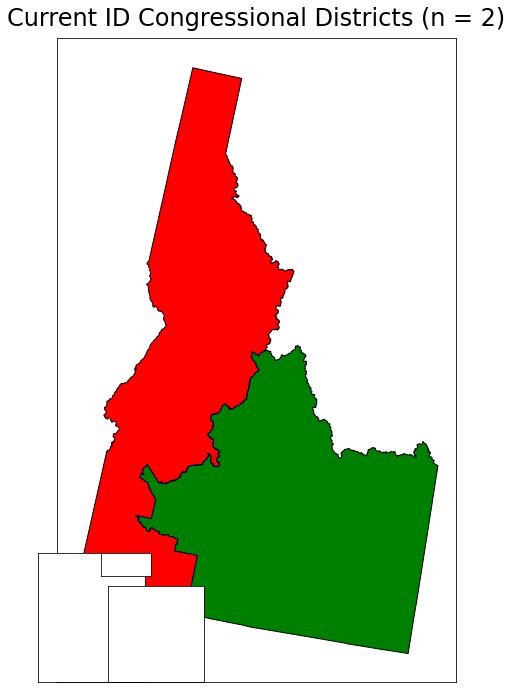

In [18]:
s = time.time()
# main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "
# alaska_crs = "epsg:3338"
# hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "


show_tracts = False
show_water = False

print('main map...')

print('\treprojecting...')

main_map_bounds = unary_union(state_gdf[state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).geometry.tolist()).bounds
main_map_aspect_ratio = (main_map_bounds[2] - main_map_bounds[0]) / (main_map_bounds[3] - main_map_bounds[1])

fig, ax = plt.subplots(1,1,figsize=(24, 24/main_map_aspect_ratio))
ax.set_aspect('equal')


print('\tplotting...')

for this_state in state_gdf[(state_gdf['STUSPS'].isin(these_states_dict.keys())) & (state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI']))]['STUSPS'].tolist():#.sort_values().tolist():
    print('\t\tPlotting {0:}...'.format(this_state))
    cdlist = cd_gdf[cd_gdf['STUSAB'] == this_state]['CD116'].drop_duplicates().sort_values().tolist()
    for i in range(1, len(cdlist)+1):
        cd_gdf[
            (cd_gdf['STUSAB'] == this_state) 
            & (cd_gdf['CD116'] == i)
        ].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black')
#         annotator = i
#         this_district_geo = unary_union(cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116'] == i)].to_crs(main_map_crs).geometry.tolist())
#         centerpoint = (this_district_geo.centroid.x, this_district_geo.centroid.y)
#         ax.annotate(annotator, centerpoint, 
#                     color='black', backgroundcolor='white', ha='center', va='center', fontsize=20)

if (show_tracts):
    print('\tplotting census tracts...')
    tract_gdf[tract_gdf['STATEFP'].apply(lambda x: x not in [2,15])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

if (show_water):
    print('\tplotting census tracts...')
    water_gdf[water_gdf['STATEFP'].apply(lambda x: x not in [2,15])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)



    
# #ax.legend(handles=legend_list, fontsize=10)


if (len(list(these_states_dict.keys())) == 1):
    ax.set_title('Current {0:} Congressional Districts (n = {1:.0f})'.format(
        list(these_states_dict.keys())[0], 
        these_states_dict[list(these_states_dict.keys())[0]]['seats_old']
    ), fontsize=24, y=1.01)
else:
    ax.set_title('Current Congressional Districts', fontsize=24, y=1.01)

# # # # ax.tick_params(axis='both', labelsize=20)

# # # # # print('saving figure...')
# # # # # fig.savefig('{0:}{1:}_old.png'.format(script_dir, list(these_states_dict.keys())[0].lower()), format='png', dpi=300, bbox_inches='tight', facecolor='white')

# # # #plt.show()
# # e = time.time()
# # g += (e-s)
# # print('Done plotting in {0:.0f} minutes {1:.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))
# # #[inset['axes_position'][0], inset['axes_position'][1], inset['axes_size'][0], inset['axes_size'][1]]

# # state_gdf[state_gdf['NAME'].apply(lambda x: x not in ['Alaska', 'Hawaii'])].to_crs(main_map_crs).plot(ax=ax)

print('AK inset...')
print('\treprojecting Alaska...')
ak_map_bounds = geopandas.GeoDataFrame(data=[[unary_union(county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAMELSAD'].apply(lambda x: 'aleutians west' not in x.lower()))].geometry.tolist())]], columns=['geometry'], crs=county_gdf.crs, geometry='geometry').to_crs(alaska_crs).bounds.values[0].tolist()
ak_map_aspect_ratio = (ak_map_bounds[2] - ak_map_bounds[0]) / (ak_map_bounds[3] - ak_map_bounds[1])

ak_inset_ax = ax.inset_axes([-0.049,0,ak_map_aspect_ratio*0.2,0.2])

#ak_inset_ax = ax.inset_axes([0,0,ak_map_aspect_ratio*1,1])

print('\t\treprojecting Aleutians West...')
aleutians_west_map_bounds = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Aleutians West')
].to_crs(alaska_crs).geometry.tolist()).bounds

aleutians_west_map_aspect_ratio = (aleutians_west_map_bounds[2] - aleutians_west_map_bounds[0]) / (aleutians_west_map_bounds[3] - aleutians_west_map_bounds[1])

# aleutians_inset_ax = ak_inset_ax.inset_axes([-0.325,-0.015,0.2*aleutians_west_map_aspect_ratio,0.2])   # to show Aletuians West in their actual geographic spot
aleutians_inset_ax = ak_inset_ax.inset_axes([0.59,0.825,0.175*aleutians_west_map_aspect_ratio,0.175])

print('plotting Alaska...')
cdlist = cd_gdf[cd_gdf['STUSAB'] == 'AK']['CD116'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'AK') & (cd_gdf['CD116'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=ak_inset_ax, color=district_color_cycle[i], edgecolor='black')
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'AK') & (cd_gdf['CD116'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] == 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=aleutians_inset_ax, color=district_color_cycle[i], edgecolor='black')
# if (show_tracts):
#     print('\tplotting census tracts...')
#     tract_gdf[tract_gdf['STUSAB'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
    

print('HI inset...')
print('\treprojecting and plotting Hawaii...')
print('\t\tremoving outer islands...')
honolulu_county_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Honolulu')
].geometry.tolist())
honolulu_county_bounds = honolulu_county_geo.bounds
fixed_honolulu_county_geo = unary_union(geopandas.overlay(
    geopandas.GeoDataFrame(data=[[honolulu_county_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'), 
    geopandas.GeoDataFrame(data=[[box(-160, honolulu_county_bounds[1], honolulu_county_bounds[2], honolulu_county_bounds[3])]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'),
    how='intersection'
).geometry.tolist())
other_hawaii_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] != 'Honolulu')
].geometry.tolist())
fixed_hawaii_geo = unary_union([other_hawaii_geo, fixed_honolulu_county_geo])
fixed_hawaii_gdf = geopandas.GeoDataFrame(data=[[fixed_hawaii_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry')

hi_map_bounds = fixed_hawaii_gdf.geometry.to_crs(hawaii_crs).geometry.apply(lambda x: x.bounds).values[0]
hi_map_aspect_ratio = (hi_map_bounds[2] - hi_map_bounds[0]) / (hi_map_bounds[3] - hi_map_bounds[1])

#print(hi_map_aspect_ratio)

hi_inset_ax = ax.inset_axes([0.128,0,hi_map_aspect_ratio*0.15,0.15])

print('plotting Hawaii...')
cdlist = cd_gdf[cd_gdf['STUSAB'] == 'HI']['CD116'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'HI') & (cd_gdf['CD116'] == i)], 
        fixed_hawaii_gdf,
        #county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(hawaii_crs).plot(ax=hi_inset_ax, color=district_color_cycle[i], edgecolor='black')

for thisax in [ax, ak_inset_ax, aleutians_inset_ax, hi_inset_ax]:
    thisax.set_xticks([])
    thisax.set_yticks([])

# print('saving figure...')
# fig.savefig(script_dir+'all-districts-orig.jpg', format='jpg', dpi=300, bbox_inches='tight')
#plt.show()
e = time.time()
g += (e-s)
print('Done plotting in {0:,.0f} seconds!'.format(e-s))

# How many districts in each state?

In [19]:
s = time.time()
for this_state_name, this_state in these_states_dict.items():
    if (this_state['seats_new'] == 1):
        these_states_dict[this_state_name]['target'] = -1
    else:
        these_states_dict[this_state_name]['target'] = cd_gdf[cd_gdf['STUSAB'] == this_state_name]['POP100'].sum() / this_state['seats_new']
    
e = time.time()
g += (e-s)
these_states_dict
#water_gdf.head(1).T

{'ID': {'STATEFP': 16, 'seats_old': 2, 'seats_new': 2, 'target': 919553.0}}

# States with one district

In [ ]:
s = time.time()
# state_target = cd_gdf['POP100'].sum() / these_states_dict[list(these_states_dict.keys())[0]]['seats_new']
tract_gdf.loc[:, 'new_district'] = np.nan

print('states with one district...')
for this_state_name, this_state in these_states_dict.items():
    if (this_state['seats_new'] == 1):
        tract_gdf.loc[tract_gdf['STUSAB'] == this_state_name, 'new_district'] = 1

e = time.time()
g += (e-s)

tract_gdf.groupby(['STUSAB', 'new_district'])['POP100'].sum()
#place_gdf.groupby(['STATEFP', 'CD116'])['POP100'].sum()


# Hawaii

In [ ]:
# # this_state = 'HI'
# # # tract_gdf.loc[['1400000US12099007710', '1400000US12099007754', '1400000US12099007764', '1400000US12099007757', '1400000US12099007771', '1400000US12099007776', '1400000US12099007779'], 'new_district'] = 22  # SW of West Palm Beach
# # # tract_gdf.loc[['1400000US12099004810', '1400000US12099004822', '1400000US12099005000'], 'new_district'] = 22  # SW of West Palm Beach
    
# # for i in range(-1, nDistricts+1):
# #     if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
# #         #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
# #         print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, 
# #                                                                                             tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
# #                                                                                             tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
# #                                                                                             tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))
# #place_gdf = place_gdf
# for ix, thisrow in place_gdf[
#         (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) #& (((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.x <= xlimits[1]))))& ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.y <= ylimits[1])))))
#     ].to_crs(equal_area_crs)[7:8].iterrows():
#     print('finding population of {0:}...'.format(thisrow['NAME']))
#     thepop = 0
#     within_tracts = tract_gdf[tract_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.within(thisrow.geometry))].index.tolist()
#     thepop += tract_gdf[tract_gdf.index.isin(within_tracts)]['POP100'].sum()
#     print('\tFound {0:,.0f} tracts entirely within, with population {1:,.0f}...'.format(len(tracts_within), thepop))
#     intersecting_tracts = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))].index.tolist()
#     print('\tFound {0:,.0f} intersecting tracts...'.format(len(intersecting_tracts)))
#     for i in range(0, len(intersecting_tracts)):
#         #if ((np.mod(i, 10) == 0) | (i == len(intersecting_tracts)-1)):
#         print('\t\tmatching tract i = {0:,.0f}...'.format(i+1))
#         total_area = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area
#         intersection_area = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(thisrow.geometry).area
#         intersection_pct = intersection_area / total_area
#         print(intersection_pct)
#     break
    
# #    print(tract_gdf[tract_gdf.index.isin(intersecting_tracts)]['POP100'].sum())
# print('Done!')


In [ ]:
s = time.time()
this_state = 'HI'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[:, 'new_district'] = np.nan
#print('states with one district...')
for this_state_name, this_state_data in these_states_dict.items():
    if (this_state_data['seats_new'] == 1):
        tract_gdf.loc[tract_gdf['STUSAB'] == this_state_name, 'new_district'] = 1


county_mapper_df = pandas.DataFrame(data=[    
    ['Kalawao County', 2],
    ['Kauai County', 2],
    ['Maui County', 2],
    ['Hawaii County', 2],
#    ['Honolulu County', 2],
], columns=['COUNTY_NAME', 'new_district_by_county'])


place_mapper_df = pandas.DataFrame(data=[
    ['Urban Honolulu',1],
    ['East Honolulu',1],    
    ['Waimanalo Beach',1],    
    ['Waimanalo',1],    
    ['Kailua',1], 
    ['Kaneohe',1],
    ['Hickam Housing',1],
    ['Ewa Beach',1],
    ['Kalaeloa',1],
    ['Kapolei', 1],
    ['Makakilo',1],
    ['Ewa Villages',1],
    ['Pearl City',1],
    ['Waimalu',1],
    ['Halawa',1],
], columns=['NAME', 'new_district_by_place'])



print('Assigning districts by county...')


tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on='COUNTY_NAME').set_index('GEOID')['new_district_by_county']

print('Assigning districts by lat/lon...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))

for i in range(1, nDistricts):
    tracts_here = []
    tracts_within = tract_gdf[
                (tract_gdf['STUSAB'] == this_state)
                & (tract_gdf['new_district'].isnull()) & 
                (tract_gdf.geometry.within(
                    unary_union(
                        place_mapper_gdf[
                            place_mapper_gdf['new_district_by_place'] == i
                        ].geometry.tolist())
                    )
                )
            ].index.tolist()
    
    tracts_here += tracts_within
#     if (len(tracts_within) > 0):
#         print('\tFinding tracts that intersect places in District {0:.0f}...'.format(i))
#         print('\t\tTracts within union of places: {0:.0f}...'.format(len(tracts_within)))
    
    tracts_intersect = tract_gdf[
                (tract_gdf['STUSAB'] == this_state)
#                & (tract_gdf['new_district'].isnull())  
                & (tract_gdf.geometry.intersects(
                    unary_union(
                        place_mapper_gdf[
                            place_mapper_gdf['new_district_by_place'] == i
                        ].geometry.tolist())
                    )
                )
                & ~(tract_gdf.index.isin(tracts_within))
            ].index.tolist()
    print('\t\tTracts within union of places: {0:.0f}...'.format(len(tracts_within)))    
    if (len(tracts_intersect) > 0):
        print('\t\tTracts that intersect union of places: {0:.0f}...'.format(len(tracts_intersect)))
        #print('\n')
        cnt = 0
        for ix, thisrow in tract_gdf[tract_gdf.index.isin(tracts_intersect)].iterrows():
            cnt += 1
            if (np.mod(cnt, 10) == 0):
                print('\t\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(tracts_intersect)))
            this_tract_area = geopandas.GeoDataFrame(data=[[tract_gdf.loc[ix].geometry]], columns=['geometry'], crs=tract_gdf.crs, geometry='geometry').to_crs(epsg=equal_area_crs).geometry.area.values[0]
            intersection_area = geopandas.GeoDataFrame(data=[[tract_gdf.loc[ix].geometry]], columns=['geometry'], crs=tract_gdf.crs, geometry='geometry').to_crs(
                epsg=equal_area_crs).geometry.intersection(
                                unary_union(
                        place_mapper_gdf[
                            place_mapper_gdf['new_district_by_place'] == i
                        ].to_crs(epsg=equal_area_crs).geometry.tolist())
                    ).to_crs(epsg=equal_area_crs).geometry.area.values[0]
            intersection_pct = intersection_area / this_tract_area

            

            #tract_gdf.to_crs(epsg=equal_area_crs).loc[ix].geometry.area
            if (intersection_pct >= desired_pct_area_overlap):
                tracts_here.append(ix)
                #print('Tract {0:}: {1:,.0f} m^2, intersection area {2:,.0f} m^2 ({3:.0%})'.format(ix, this_tract_area, intersection_area, intersection_pct))
            #break
        
        print('\t\tAssigning {0:.0f} place-matching tracts in District {1:.0f}!'.format(len(tracts_here), i))
        print('\n')
        tract_gdf.loc[tracts_here, 'new_district'] = i


# # since zero-population tracts don't matter anyway, unless we need them for map clarification
# #tract_gdf.loc[tract_gdf['POP100'] == 0, 'new_district'] = np.nan

print('Assigning districts by tract number...')

tract_gdf.loc[['1400000US15003010309', '1400000US15003010310', '1400000US15003010505', '1400000US15003981803'], 'new_district'] = 1   # east coast near Kailua/Kaneohe
tract_gdf.loc[['1400000US15003011000', '1400000US15003940004', '1400000US15003980800', '1400000US15003981000', '1400000US15003981100'], 'new_district'] = 1 # Kaneohe/Kailua
tract_gdf.loc[['1400000US15003010308'], 'new_district'] = 1 # Punchbowl


tract_gdf.loc[['1400000US15003007400', '1400000US15003007701'], 'new_district'] = 1 # Pearl City
tract_gdf.loc[['1400000US15003007702', '1400000US15003007815', '1400000US15003007816', '1400000US15003008005'], 'new_district'] = 1 # Pearl City


tract_gdf.loc[['1400000US15003008301', '1400000US15003008405', '1400000US15003008407', '1400000US15003008408', '1400000US15003008410', '1400000US15003008411', '1400000US15003008414', '1400000US15003008415', '1400000US15003008416', '1400000US15003008417'], 'new_district'] = 1 # Between Honolulu and Ewa Beach

tract_gdf.loc[['1400000US15003980300', '1400000US15003982200', '1400000US15003008609', '1400000US15003008610', '1400000US15003008624', '1400000US15003008706', '1400000US15003007507'], 'new_district'] = 1 # Between Honolulu and Ewa Beach

tract_gdf.loc[['1400000US15001021504', '1400000US15001021605', '1400000US15001021606', '1400000US15001021607', '1400000US15001021608'], 'new_district'] = 2 # Weird tracts on Big Island
    
    
    
print('All the rest are district 2...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 2

print('Except ocean tracts...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')



for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):

        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

# #tract_gdf.groupby(['STUSAB', 'new_district'])['POP100'].sum()

# 536282
#these_states_dict[this_state]

In [ ]:
s = time.time()
show_water = True
show_roads = False
show_small_roads = False
label_tracts = False

show_places = False
label_places = False

#show_counties = True
#label_counties = True

the_label_size = 20
the_annotation_size = 22
the_line_width = .5
the_line_width_wide = 6
the_legend_size = 18
the_title_size = 28

#bounds_counties = []

# if (len(bounds_counties) > 0):
#     xlimits = [-162, unary_union(county_gdf[county_gdf['NAME'].isin(bounds_counties)].geometry.tolist()).bounds[2]]
#     ylimits = [unary_union(county_gdf[county_gdf['NAME'].isin(bounds_counties)].geometry.tolist()).bounds[1], 23]
# else:
#     xlimits = [-161, unary_union(state_gdf[state_gdf['STUSPS'] == this_state].geometry.tolist()).bounds[2]]
#     ylimits = [unary_union(state_gdf[state_gdf['STUSPS'] == this_state].geometry.tolist()).bounds[1], 22.5]


# Hawaii    
xlimits = [800000, unary_union(state_gdf[state_gdf['STUSPS'] == this_state].to_crs(hawaii_crs).geometry.tolist()).bounds[2]]
ylimits = [unary_union(state_gdf[state_gdf['STUSPS'] == this_state].to_crs(hawaii_crs).geometry.tolist()).bounds[1], 400000]

# Oahu
# xlimits = [1.55e6, 1.75e6]
# ylimits = [0.01e6,0.18e6]

# # South coast of Oahu
# xlimits = [1.6e6,1.75e6]
# ylimits = [.03e6,.11e6]

# Southeast coast of Oahu
# xlimits = [1.7e6,1.75e6]
# ylimits = [.09e6,.11e6]

# Southwest Oahu
# xlimits = [1.57e6,1.7e6]
# ylimits = [.04e6,.11e6]

# West of Pearl Harbor Area
# xlimits = [1.59e6,1.66e6]
# ylimits = [0.04e6,0.11e6]


# Pearl City area
# xlimits = [1.65e6,1.7e6]
# ylimits = [.06e6,.105e6]

xspan = xlimits[1] - xlimits[0]
yspan = ylimits[1] - ylimits[0]
aspect_ratio = xspan / yspan

xbuffer = xspan * map_buffer_ratio
ybuffer = yspan * map_buffer_ratio

xlimits = [xlimits[0] - xbuffer, xlimits[1] + xbuffer] #cd_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
ylimits = [ylimits[0] - ybuffer, ylimits[1] + ybuffer] 

print('xspan = {0:,.2f} km'.format(xspan/1000))
print('aspect_ratio  = {0:,.2f}:1'.format(aspect_ratio))
print('\n')

# fig, ax = plt.subplots(1,1, figsize=(xspan*scale, yspan*scale))
fig, ax = plt.subplots(1,1,figsize=(24, 24/aspect_ratio))
ax.set_aspect('equal')

# print('plotting CBSAs...')
# cbsa_gdf[
#     ((cbsa_gdf['INTPTLON'] >= xlimits[0]) & (cbsa_gdf['INTPTLON'] <= xlimits[1]))
#     & ((cbsa_gdf['INTPTLAT'] >= ylimits[0]) & (cbsa_gdf['INTPTLAT'] <= ylimits[1]))
# ].plot(ax=ax, color='none', edgecolor='yellow')


print('plotting tracts...')

# base layer
legend_list = []
for i in range(-1,these_states_dict[this_state]['seats_new']+1):
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        #print(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum())
        tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)].to_crs(hawaii_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black', linewidth=the_line_width)#, alpha=0.25)        
        legend_list.append(mpatches.Patch(color=district_color_cycle[i], label='District {0:,.0f}'.format(i)))

tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull())].to_crs(hawaii_crs).plot(ax=ax, color='none', edgecolor='gray', lw=the_line_width)


if (label_tracts):
    print('labeling tracts...')
    for ix, thisrow in tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (((tract_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((tract_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.x <= xlimits[1])))) & ((tract_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((tract_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.y <= ylimits[1]))))
          )
        #& (tract_gdf['new_district'].isnull())
        & (tract_gdf['new_district'] == 2)
    ].to_crs(hawaii_crs).sort_values(by=['COUNTY_NAME', 'census_tract']).iterrows():
        #print('{0:}-{1:}:\t{2:}'.format(thisrow['COUNTY_NAME'][0:3],thisrow['census_tract'], ix))
        print('{0:}:\t{1:}'.format(thisrow['census_tract'], ix))
        #annotator = '{0:}-{1:}\n{2:,.0f}'.format(thisrow['COUNTY_NAME'][0:3],thisrow['census_tract'], geo_df.loc[ix]['POP100'])
        annotator = '{0:}\n{1:,.0f}'.format(thisrow['census_tract'], geo_df.loc[ix]['POP100'])
        centerpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
        ax.annotate(annotator, centerpoint, 
                    color='gray', backgroundcolor='white', ha='center', va='center', 
                    fontsize=the_annotation_size)

if (show_places):
    print('plotting places...')
    place_gdf[
        (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])& (((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.x <= xlimits[1]))))& ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.y <= ylimits[1])))))
    ].to_crs(hawaii_crs).plot(ax=ax, edgecolor='red', lw=the_line_width_wide, color='none')

if (label_places):
    print('labeling places...')
    for ix, thisrow in place_gdf[
        (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])& (((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.x <= xlimits[1]))))& ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.y <= ylimits[1])))))
    ].to_crs(hawaii_crs).iterrows():
#        print(thisrow['NAME'])
        annotator = thisrow['NAME'].replace(' ','\n')
        centerpoint = [thisrow.geometry.centroid.x, thisrow.geometry.centroid.y]
        ax.annotate(annotator, centerpoint, 
                    color='red', backgroundcolor='white', ha='center', va='center', 
                    fontsize=the_annotation_size)

if (show_water):
    print('plotting water areas...')
    water_gdf[water_gdf['STUSAB'] == this_state].to_crs(hawaii_crs).plot(ax=ax, color='blue')

    
# if (show_roads):
#     print('plotting roads...')
#     if (show_small_roads):
#         print('\tsmall...')
#         roads_gdf[~roads_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax, color='black', linewidth=0.1)
#     print('\tlarge...')
#     roads_gdf[roads_gdf['RTTYP'] == 'C'].plot(ax=ax, color='black', linewidth=0.25) 
#     roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=0.5) 
#     roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=0.75)     
#     roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax, color='black', linewidth=1) 

# if (show_counties):
#     print('\n')
#     print('plotting state and county borders...')
#     if (len(bounds_counties) > 0):   
#         county_gdf[county_gdf['NAME'].isin(bounds_counties)].plot(ax=ax, color='none', edgecolor='black', linewidth=2)
#     else:
#         county_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=2)
#     state_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width_wide)
# if (label_counties):
#     print('labeling counties...')
#     for ix, thisrow in county_gdf[
#         (county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
#         & (
#             ((county_gdf['INTPTLON'] >= xlimits[0]) & (county_gdf['INTPTLON'] <= xlimits[1])) 
#             & ((county_gdf['INTPTLAT'] >= ylimits[0]) & (county_gdf['INTPTLAT'] <= ylimits[1])))
#     ].iterrows():
#         ax.annotate('{0:}'.format(thisrow['NAME']), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), color='gray', backgroundcolor='white', ha='center', va='center',  fontsize=the_annotation_size)

plt.xlim(xlimits)
plt.ylim(ylimits)

#ax.set_xticks(np.arange(xlimits[0], xlimits[1], xspan/10))#, fontsize=the_label_size)
#ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_tick_params(labelbottom=True, labeltop=True, labelsize=the_label_size)

#ax.set_yticks(np.arange(27.8, 28.8, 0.025))
ax.yaxis.set_tick_params(labelleft=True, labelright=True, labelsize=the_label_size)

ax.legend(handles=legend_list, fontsize=the_legend_size, loc='lower left')

if (len(list(these_states_dict.keys())) == 1):
    plt.title('New {0:} Congressional Districts (n = {1:.0f})'.format(
        list(these_states_dict.keys())[0], 
        these_states_dict[list(these_states_dict.keys())[0]]['seats_new']
    ), fontsize=the_title_size)
else:    
    plt.title('New Congressional Districts', fontsize=the_title_size)



plt.show()
print('\n')
for i in range(1, these_states_dict[this_state]['seats_new']+1):
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, 
                                                                                            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
                                                                                            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
                                                                                            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target)
             )
e = time.time()
g += (e-s)

# IDAHO

In [ ]:
s = time.time()
this_state = 'ID'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
    ['Ada County',1],
    ['Adams County',1],
    ['Boise County',1],
    ['Camas County',1],
    ['Canyon County',1],
    ['Elmore County',1],
    ['Gem County',1],
    ['Gooding County',1],
    ['Owyhee County',1],
    ['Payette County',1],
    #['Twin Falls County',1],
   ['Washington County',1],
], columns=['COUNTY_NAME', 'new_district_by_county'])


place_mapper_df = pandas.DataFrame(data=[
    #['Boise City',1]
    ['Twin Falls', 1]
], columns=['NAME', 'new_district_by_place'])

    
print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on='COUNTY_NAME').set_index('GEOID')['new_district_by_county']


#print('Assigning districts by lat/lon...')
# tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    tracts_here = []
    tracts_within = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())))].index.tolist()
    tracts_here += tracts_within
    tracts_intersecting = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) 
              & (tract_gdf.geometry.intersects(unary_union(place_mapper_gdf.geometry.tolist())))
              & ~(tract_gdf.index.isin(tracts_within))
             ].index.tolist()
    for this_tract in tracts_intersecting:
        total_tract_area_geo = tract_gdf.loc[this_tract].geometry.area
        #total_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area

        intersection_tract_area_geo = tract_gdf.loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())).area
        #intersection_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf.to_crs(equal_area_crs).geometry.tolist())).area
        
        intersection_tract_pct = intersection_tract_area_geo / total_tract_area_geo
        if (intersection_tract_pct >= 0.5):
            tracts_here.append(this_tract)
    tract_gdf.loc[tracts_here, 'new_district'] = i

    
print('Assigning districts by tract number...')
# tract_gdf.loc[['1400000US16083000300', '1400000US16083000400', '1400000US16083000500', '1400000US16083001600'], 'new_district'] = np.nan   # Twin Falls County but not city
# tract_gdf.loc[['1400000US16083000600', '1400000US16083001301', '1400000US16083001302'], 'new_district'] = np.nan   # Twin Falls County but not city
# tract_gdf.loc[['1400000US16083000701', '1400000US16083000900'], 'new_district'] = np.nan   # Twin Falls County but not city


tract_gdf.loc[['1400000US16083000300', '1400000US16083000400', '1400000US16083001600'], 'new_district'] = 1  # Twin Falls County but not city
tract_gdf.loc[['1400000US16083000600', '1400000US16083000701'], 'new_district'] = 1  




tract_gdf.loc[['1400000US16083001301', '1400000US16083001302'], 'new_district'] = 2   # Twin Falls County but not city
tract_gdf.loc[['1400000US16083000500', '1400000US16083000900'], 'new_district'] = 2   #  Twin Falls County but not city



# # print('All the rest are district 2...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 2

# # print('Except ocean tracts...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')

    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):

        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        

#place_gdf[place_gdf['STATEFP'] == 16].sort_values(by='NAME')[20:]


# MONTANA

In [ ]:
s = time.time()
this_state = 'MT'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
    ['Blaine County',1],
    ['Phillips County',1],
    ['Valley County',1],
    ['Daniels County',1],
    ['Roosevelt County',1],
    ['Sheridan County',1],
    ['Fergus County',1],
    ['Petroleum County',1], 
    ['Garfield County',1],
    ['McCone County',1], 
    ['Richland County',1], 
    ['Dawson County',1], 
    ['Prairie County',1], 
    ['Wibaux County',1],
    ['Wheatland County',1], 
    ['Green Valley County',1], 
    ['Musselshell County',1], 
    ['Treasure County',1], 
    ['Custer County',1], 
    ['Fallon County',1],
    ['Park County',1], 
    ['Stillwater County',1], 
    ['Carbon County',1], 
    ['Yellowstone County',1], 
    ['Big Horn County',1], 
    ['Powder River County',1], 
    ['Carter County',1],
    ['Rosebud County',1],
    ['Sweet Grass County',1],
    ['Toole County',1],
    ['Liberty County',1],
    ['Hill County',1],
    ['Chouteau County',1],
    ['Judith Basin County',1],    
    ['Golden Valley County',1],
    ['Pondera County',1],
    ['Teton County',1],
    ['Glacier County',1],
    ['Cascade County',1],
    ['Meagher County',1],
    ['Broadwater County',1],
    ['Lewis and Clark County',1],
], columns=['COUNTY_NAME', 'new_district_by_county'])


place_mapper_df = pandas.DataFrame(data=[
    #['Boise City',1]
    #['Twin Falls', 1]
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on='COUNTY_NAME').set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


# print('Assigning districts by place...')
# place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


# print('\n')
# for i in range(1, nDistricts+1):
#     tracts_here = []
#     tracts_within = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())))].index.tolist()
#     tracts_here += tracts_within
#     tracts_intersecting = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) 
#               & (tract_gdf.geometry.intersects(unary_union(place_mapper_gdf.geometry.tolist())))
#               & ~(tract_gdf.index.isin(tracts_within))
#              ].index.tolist()
#     for this_tract in tracts_intersecting:
#         total_tract_area_geo = tract_gdf.loc[this_tract].geometry.area
#         #total_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area

#         intersection_tract_area_geo = tract_gdf.loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())).area
#         #intersection_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf.to_crs(equal_area_crs).geometry.tolist())).area
        
#         intersection_tract_pct = intersection_tract_area_geo / total_tract_area_geo
#         if (intersection_tract_pct >= 0.5):
#             tracts_here.append(this_tract)
#     tract_gdf.loc[tracts_here, 'new_district'] = i

    
#print('Assigning districts by tract number...')



# # print('All the rest are district 2...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 2

# # # print('Except ocean tracts...')
# # # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')

#print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        

#place_gdf[place_gdf['STATEFP'] == 16].sort_values(by='NAME')[20:]
#county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]['NAME'].sort_values()


# WEST VIRGINIA

In [ ]:
s = time.time()
this_state = 'WV'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
    ['Mason County',1],
     ['Putnam County',1],
     ['Kanawha County',1],
     ['Fayette County',1],
     ['Greenbrier County',1],
     ['Cabell County',1],
     ['Lincoln County',1],
     ['Boone County',1],
     ['Raleigh County',1],
     ['Summers County',1],
      ['Monroe County',1],
      ['Wayne County',1],
     ['Logan County',1],
     ['Wyoming County',1],
     ['Mercer County',1],
     ['Mingo County',1],
     ['McDowell County',1],
    ['Nicholas County',1],
    ['Clay County',1],
    ['Jackson County',1],
    ['Roane County',1],
    ['Braxton County',1],
     ['Wirt County',1],
    ['Calhoun County',1],
    ['Gilmer County',1],
    ['Webster County',1],
    ['Lewis County',1],
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
    #['Boise City',1]
    #['Twin Falls', 1]
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    tracts_here = []
    tracts_within = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())))].index.tolist()
    tracts_here += tracts_within
    tracts_intersecting = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) 
              & (tract_gdf.geometry.intersects(unary_union(place_mapper_gdf.geometry.tolist())))
              & ~(tract_gdf.index.isin(tracts_within))
             ].index.tolist()
    for this_tract in tracts_intersecting:
        total_tract_area_geo = tract_gdf.loc[this_tract].geometry.area
        #total_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area

        intersection_tract_area_geo = tract_gdf.loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())).area
        #intersection_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf.to_crs(equal_area_crs).geometry.tolist())).area
        
        intersection_tract_pct = intersection_tract_area_geo / total_tract_area_geo
        if (intersection_tract_pct >= 0.5):
            tracts_here.append(this_tract)
    tract_gdf.loc[tracts_here, 'new_district'] = i

    
print('Assigning districts by tract number...')



# print('All the rest are district 2...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 2

# # # print('Except ocean tracts...')
# # # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')

#print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        

#place_gdf[place_gdf['STATEFP'] == 16].sort_values(by='NAME')[20:]
#county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]['NAME'].sort_values()


# RHODE ISLAND

In [ ]:
s = time.time()
this_state = 'RI'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
    ['Providence',1],
    ['East Providence',1],
    ['Cranston',1],
    ['Warwick',1],
    ['Pawtucket',1],
    ['Central Falls',1],
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    tracts_here = []
    tracts_within = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())))].index.tolist()
    tracts_here += tracts_within
    tracts_intersecting = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) 
              & (tract_gdf.geometry.intersects(unary_union(place_mapper_gdf.geometry.tolist())))
              & ~(tract_gdf.index.isin(tracts_within))
             ].index.tolist()
    for this_tract in tracts_intersecting:
        total_tract_area_geo = tract_gdf.loc[this_tract].geometry.area
        #total_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area

        intersection_tract_area_geo = tract_gdf.loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())).area
        #intersection_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf.to_crs(equal_area_crs).geometry.tolist())).area
        
        intersection_tract_pct = intersection_tract_area_geo / total_tract_area_geo
        if (intersection_tract_pct >= 0.5):
            tracts_here.append(this_tract)
    tract_gdf.loc[tracts_here, 'new_district'] = i

    
print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US44007011800', '1400000US44007011901', '1400000US44007011902', '1400000US44007012000', '1400000US44007012102', '1400000US44007012103', '1400000US44007012104'], 'new_district'] = 1   # NW of Providence
tract_gdf.loc[['1400000US44007011701', '1400000US44007011702'], 'new_district'] = 1   # NW of Providence
    
    
# print('All the rest are district 2...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 2

print('Except ocean tracts...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')

print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        

#place_gdf[place_gdf['STATEFP'] == 16].sort_values(by='NAME')[20:]
#county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]['NAME'].sort_values()


# NEW HAMPSHIRE

In [ ]:
s = time.time()
this_state = 'NH'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
    ['Hillsborough County',1],
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
    ['Londonderry',1],
    ['Derry',1],
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    tracts_here = []
    tracts_within = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())))].index.tolist()
    tracts_here += tracts_within
    tracts_intersecting = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) 
              & (tract_gdf.geometry.intersects(unary_union(place_mapper_gdf.geometry.tolist())))
              & ~(tract_gdf.index.isin(tracts_within))
             ].index.tolist()
    for this_tract in tracts_intersecting:
        total_tract_area_geo = tract_gdf.loc[this_tract].geometry.area
        #total_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area

        intersection_tract_area_geo = tract_gdf.loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())).area
        #intersection_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf.to_crs(equal_area_crs).geometry.tolist())).area
        
        intersection_tract_pct = intersection_tract_area_geo / total_tract_area_geo
        if (intersection_tract_pct >= 0.5):
            tracts_here.append(this_tract)
    tract_gdf.loc[tracts_here, 'new_district'] = i

    
print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US33015003301', '1400000US33015003302', '1400000US33015003601', '1400000US33015003602', '1400000US33015003703', '1400000US33015003801', '1400000US33015003802', '1400000US33015004000'], 'new_district'] = 1   #   N of Derry
tract_gdf.loc[['1400000US33015100100', '1400000US33015100200', '1400000US33015100301', '1400000US33015100302', '1400000US33015100401', '1400000US33015100402', '1400000US33015105100', '1400000US33015106101', '1400000US33015106102'], 'new_district'] = 1    # E of Londonderry
tract_gdf.loc[['1400000US33015050000', '1400000US33015051000', '1400000US33015052000', '1400000US33015053000', '1400000US33015054000', '1400000US33015055001', '1400000US33015055002', '1400000US33015059000', '1400000US33015060000'], 'new_district'] = 1   #   S of Hooksett
tract_gdf.loc[['1400000US33015102100', '1400000US33015103100', '1400000US33015104101', '1400000US33015104102', '1400000US33015101101', '1400000US33015101102'], 'new_district'] = 1   #   E of Derry
tract_gdf.loc[['1400000US33015062000', '1400000US33015062500', '1400000US33015063001', '1400000US33015063003', '1400000US33015063004'], 'new_district'] = 1  # Southern border
tract_gdf.loc[['1400000US33015064000', '1400000US33015065005', '1400000US33015065006', '1400000US33015065007', '1400000US33015065008', '1400000US33015065009', '1400000US33015065010'], 'new_district'] = 1  # Southern border
tract_gdf.loc[['1400000US33015061001', '1400000US33015106200', '1400000US33015106400'], 'new_district'] = 1  # Exeter
tract_gdf.loc[['1400000US33015066000', '1400000US33015067000'], 'new_district'] = 1  # Near Portsmouth
tract_gdf.loc[['1400000US33015067502', '1400000US33015067503', '1400000US33015067504', '1400000US33015067505'], 'new_district'] = 1  # Newmarket
tract_gdf.loc[['1400000US33015980011'], 'new_district'] = 1  # Misc whatever


## print('All the rest are district 2...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 2

#print('Except ocean tracts...')
#tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')

print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        

#place_gdf[place_gdf['STATEFP'] == 16].sort_values(by='NAME')[20:]
#county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]['NAME'].sort_values()
print('doNE!')

# MAINE

In [ ]:
s = time.time()
this_state = 'ME'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
    ['York County',1],
   ['Cumberland County',1],
   ['Sagadahoc County',1],
    ['Lincoln County',1],
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
    ['Auburn',1],
    ['Lewiston',1],
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    tracts_here = []
    tracts_within = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())))].index.tolist()
    tracts_here += tracts_within
    tracts_intersecting = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) 
              & (tract_gdf.geometry.intersects(unary_union(place_mapper_gdf.geometry.tolist())))
              & ~(tract_gdf.index.isin(tracts_within))
             ].index.tolist()
    for this_tract in tracts_intersecting:
        total_tract_area_geo = tract_gdf.loc[this_tract].geometry.area
        #total_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area

        intersection_tract_area_geo = tract_gdf.loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())).area
        #intersection_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf.to_crs(equal_area_crs).geometry.tolist())).area
        
        intersection_tract_pct = intersection_tract_area_geo / total_tract_area_geo
        if (intersection_tract_pct >= 0.5):
            tracts_here.append(this_tract)
    tract_gdf.loc[tracts_here, 'new_district'] = i

    
print('Assigning districts by tract number...')
#tract_gdf.loc[['1400000US33015003301', '1400000US33015003302', '1400000US33015003601', '1400000US33015003602', '1400000US33015003703', '1400000US33015003801', '1400000US33015003802', '1400000US33015004000'], 'new_district'] = 1   #   N of Derry


tract_gdf.loc[['1400000US23001030100', '1400000US23001030200', '1400000US23001040000', '1400000US23001041000', '1400000US23001041500', '1400000US23001046000', '1400000US23001046500'], 'new_district'] = 1 # E of Auburn/Lewiston


# print('All the rest are district 2...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 2

#print('Except ocean tracts...')
#tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')

print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        

#place_gdf[place_gdf['STATEFP'] == 16].sort_values(by='NAME')[20:]
#county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]['NAME'].sort_values()
print('doNE!')

# NEBRASKA

In [ ]:
s = time.time()
this_state = 'NE'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
    ['Washington County',2],
    ['Cass County',2],
    ['Saunders County',2],
    ['Lancaster County',2],
    ['Otoe County',2],
    ['Dodge County',2],
    ['Burt County',2],
    ['Cuming County',2],
    ['Gage County',2],
    ['Johnson County',2],
    ['Pawnee County',2],
    ['Nemaha County',2],
    ['Richardson County',2],
    ['Thurston County',2],
    ['Dakota County',2],
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
    ['Omaha',1],
    ['Ralston',1],
    ['Papillion',1],
    ['Bellevue',1],
    ['Waterloo',1],
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    tracts_here = []
    tracts_within = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())))].index.tolist()
    tracts_here += tracts_within
    tracts_intersecting = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) 
              & (tract_gdf.geometry.intersects(unary_union(place_mapper_gdf.geometry.tolist())))
              & ~(tract_gdf.index.isin(tracts_within))
             ].index.tolist()
    for this_tract in tracts_intersecting:
        total_tract_area_geo = tract_gdf.loc[this_tract].geometry.area
        #total_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area

        intersection_tract_area_geo = tract_gdf.loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())).area
        #intersection_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf.to_crs(equal_area_crs).geometry.tolist())).area
        
        intersection_tract_pct = intersection_tract_area_geo / total_tract_area_geo
        if (intersection_tract_pct >= 0.5):
            tracts_here.append(this_tract)
    tract_gdf.loc[tracts_here, 'new_district'] = i

    
print('Assigning districts by tract number...')

tract_gdf.loc[['1400000US31055007473'], 'new_district'] = 1   # south central Omaha
tract_gdf.loc[['1400000US31055007515', '1400000US31055007516'], 'new_district'] = 1   # south west Omaha
tract_gdf.loc[['1400000US31055007519'], 'new_district'] = 1   # west Omaha
tract_gdf.loc[['1400000US31055007309', '1400000US31055007314', '1400000US31055007316', '1400000US31055007315', '1400000US31055007319'], 'new_district'] = 1   # north Omaha
tract_gdf.loc[['1400000US31153010103', '1400000US31153010203', '1400000US31153010204', '1400000US31153010302', '1400000US31153010305', '1400000US31153010306'], 'new_district'] = 1   # NE Sarpy County
tract_gdf.loc[['1400000US31153010504', '1400000US31153010615', '1400000US31153010620', '1400000US31153010621', '1400000US31153010622', '1400000US31153010623', '1400000US31153010624', '1400000US31153010637', '1400000US31153010614'], 'new_district'] = 1   # NE Sarpy County


tract_gdf.loc[['1400000US31055007303', '1400000US31055007317', '1400000US31055007318', '1400000US31055007504', '1400000US31055007505', '1400000US31055007506', '1400000US31055007508', '1400000US31055007509', '1400000US31055007517', '1400000US31055007521', '1400000US31055007522'], 'new_district'] = 2   #  Rest of Douglas County
tract_gdf.loc[['1400000US31153010208', '1400000US31153010209', '1400000US31153010625', '1400000US31153010626', '1400000US31153010627', '1400000US31153010629', '1400000US31153010630'], 'new_district'] = 2   #  Rest of Sarpy County
tract_gdf.loc[['1400000US31153010631', '1400000US31153010632', '1400000US31153010633', '1400000US31153010634', '1400000US31153010635', '1400000US31153010636', '1400000US31153010701', '1400000US31153010702'], 'new_district'] = 2   #  Rest of Sarpy County


               
## print('All the rest are district 3...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 3

#print('Except ocean tracts...')
#tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')

print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        

#place_gdf[place_gdf['STATEFP'] == 16].sort_values(by='NAME')[20:]
#county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]['NAME'].sort_values()
print('doNE!')

# NEW MEXICO

In [ ]:
s = time.time()
this_state = 'NM'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
     ['Valencia County',2],
     ['Torrance County',2],
     ['Doña Ana County',2],
     ['Socorro County',2],
     ['Sierra County',2],
     ['Cibola County',2], 
     ['Catron County',2], 
     ['Lincoln County',2], 
     ['Otero County',2], 
     ['Grant County',2], 
     ['Hidalgo County',2],
     ['Luna County',2], 
     ['Lee County',2], 
     ['Eddy County',2], 
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
    ['Albuquerque',1],
    ['Rio Rancho',1],
    ['South Valley',1],    
    ['North Valley',1],
    ['Corrales',1],
    ['Los Ranchos de Albuquerque',1],
    ['Roswell',2],
    ['Midway',2],
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    tracts_here = []
    tracts_within = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())))].index.tolist()
    tracts_here += tracts_within
    if (len(tracts_within) > 0):
        print('\tFinding tracts that intersect places in District {0:.0f}...'.format(i))
        print('\t\tTracts within union of places: {0:.0f}...'.format(len(tracts_within)))
    
    tracts_intersecting = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) 
              & (tract_gdf.geometry.intersects(unary_union(place_mapper_gdf.geometry.tolist())))
              & ~(tract_gdf.index.isin(tracts_within))
             ].index.tolist()

    if (len(tracts_intersecting) > 0):
        print('\t\tTracts that intersect union of places: {0:.0f}...'.format(len(tracts_intersecting)))
    
    cnt = 0
    for this_tract in tracts_intersecting:
        if (np.mod(cnt, 10) == 0):
            print('\t\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(tracts_intersecting)))
        
        total_tract_area_geo = tract_gdf.loc[this_tract].geometry.area
        #total_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area

        intersection_tract_area_geo = tract_gdf.loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())).area
        #intersection_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf.to_crs(equal_area_crs).geometry.tolist())).area
        
        intersection_tract_pct = intersection_tract_area_geo / total_tract_area_geo
        if (intersection_tract_pct >= 0.5):
            tracts_here.append(this_tract)
        cnt += 1
    tract_gdf.loc[tracts_here, 'new_district'] = i

    
print('Assigning districts by tract number...')

tract_gdf.loc[['1400000US35001004722', '1400000US35001004761', '1400000US35001980300', '1400000US35001004735', '1400000US35043980000'], 'new_district'] = 1   # ABQ area


tract_gdf.loc[['1400000US35001000720', '1400000US35001003729', '1400000US35001003731', '1400000US35001003741', '1400000US35001003742', '1400000US35001003744'], 'new_district'] = 2   # Rest of Bernalillo County
tract_gdf.loc[['1400000US35001003805', '1400000US35001004712', '1400000US35001004715', '1400000US35001004736', '1400000US35001004744', '1400000US35001940500', '1400000US35001940602', '1400000US35001940700', '1400000US35001940800', '1400000US35001980500'], 'new_district'] = 2   # Rest of Bernalillo County
tract_gdf.loc[['1400000US35001003803', '1400000US35001003804', '1400000US35001003806', '1400000US35001003807', '1400000US35001980000'], 'new_district'] = 2  # Rest of Bernanillo County
tract_gdf.loc[['1400000US35005001102'], 'new_district'] = 2    # Chaves County west of Roswell
tract_gdf.loc[['1400000US35005000400', '1400000US35005000600', '1400000US35005000900', '1400000US35005001002', '1400000US35005001101'], 'new_district'] = 2    # Roswell area


tract_gdf.loc[['1400000US35043010503', '1400000US35043010722', '1400000US35043010734', '1400000US35043011101', '1400000US35043940500', '1400000US35043940700'], 'new_district'] = 3   # Rest of Sandoval County
tract_gdf.loc[['1400000US35043010900', '1400000US35043011102', '1400000US35043011200', '1400000US35043940200', '1400000US35043940300', '1400000US35043940600', '1400000US35043940900', '1400000US35043941000'], 'new_district'] = 3   # Rest of Sandoval County
tract_gdf.loc[['1400000US35049010304', '1400000US35049010308', '1400000US35049010900', '1400000US35049940300', '1400000US35049980000'], 'new_district'] = 3   # Rest of Sandoval County


# print('All the rest are district 3...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 3

#print('Except ocean tracts...')
#tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')

print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        

#place_gdf[place_gdf['STATEFP'] == 16].sort_values(by='NAME')[20:]
#county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]['NAME'].sort_values()
print('doNE!')

# ARKANSAS

In [ ]:
s = time.time()
this_state = 'AR'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
    ['Faulkner County',2],
    ['Grant County',2],
    ['Lonoke County',2],
    ['Perry County',2],
    ['Pulaski County',2],
    ['Saline County',2],
    ['Benton County',3],
    ['Washington County',3],
    ['Crawford County',3],
    ['Franklin County',3],
    ['Sebastian County',3],
    ['Madison County',3],
    ['Craighead County',1],
    ['Poinsett County',1],
    ['Clay County',1],
    ['Mississippi County',1],
    ['Sharp County',1],
    ['Randolph County',1],
    ['Lawrence County',1],
    ['Independence County',1],
    ['Jackson County',1],
    ['Fulton County',1],
    ['Izard County',1],
    ['Sloane County',1],
    ['Baxter County',1],
    ['White County',1],
    ['Cleburne County',1],
    ['Van Buren County',1],
    ['Stone County',1],
    ['Marion County',1],
    ['Boone County',1],
    ['Carroll County',1],
    ['Searcy County',1],
    ['Newton County',1],
    ['Johnson County',1],
    ['Pope County',1],
    ['Conway County',1],
    ['Greene County',1],
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    tracts_here = []
    tracts_within = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())))].index.tolist()
    tracts_here += tracts_within
    if (len(tracts_within) > 0):
        print('\tFinding tracts that intersect places in District {0:.0f}...'.format(i))
        print('\t\tTracts within union of places: {0:.0f}...'.format(len(tracts_within)))
    
    tracts_intersecting = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) 
              & (tract_gdf.geometry.intersects(unary_union(place_mapper_gdf.geometry.tolist())))
              & ~(tract_gdf.index.isin(tracts_within))
             ].index.tolist()

    if (len(tracts_intersecting) > 0):
        print('\t\tTracts that intersect union of places: {0:.0f}...'.format(len(tracts_intersecting)))
    
    cnt = 0
    for this_tract in tracts_intersecting:
        if (np.mod(cnt, 10) == 0):
            print('\t\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(tracts_intersecting)))
        
        total_tract_area_geo = tract_gdf.loc[this_tract].geometry.area
        #total_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area

        intersection_tract_area_geo = tract_gdf.loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())).area
        #intersection_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf.to_crs(equal_area_crs).geometry.tolist())).area
        
        intersection_tract_pct = intersection_tract_area_geo / total_tract_area_geo
        if (intersection_tract_pct >= 0.5):
            tracts_here.append(this_tract)
        cnt += 1
    tract_gdf.loc[tracts_here, 'new_district'] = i

    
print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US05149952301', '1400000US05149952302', '1400000US05149952402'], 'new_district'] = 1    # Yell County peninsula thing
   
### print('All the rest are district 4...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 4

#print('Except ocean tracts...')
#tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')

print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        

#place_gdf[place_gdf['STATEFP'] == 16].sort_values(by='NAME')[20:]
#county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]['NAME'].sort_values()
print('doNE!')

# IOWA

In [ ]:
s = time.time()
this_state = 'IA'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
    ['Polk County',3],
    ['Dallas County',3],
    ['Warren County',3],
    ['Madison County',3],
    ['Guthrie County',3],
    ['Jasper County',3],
     ['Scott County',1],
    ['Linn County',1],
    ['Johnson County',1],
    ['Cedar County',1],
    ['Jones County',1],
    ['Jackson County',1],
    ['Clinton County',1],
    ['Dubuque County',1],
    ['Sioux County',4],
    ['Lyon County',4],
    ['Osceola County',4],
    ["O'Brien County",4],
    ['Dickinson County',4],
    ['Clay County',4],
    ['Emmet County',4],
    ['Palo Alto County',4],
    ['Plymouth County',4],
    ['Cherokee County',4],
     ['Kossuth County',4],
    ['Winnebago County',4],
    ['Hancock County',4],
     ['Buena Vista County',4],
    ['Pocahontas County',4],
    ['Humboldt County',4],
    ['Wright County',4],
    ['Woodbury County',4],
    ['Ida County',4],
    ['Sac County',4],
    ['Calhoun County',4],
    ['Webster County',4],
    ['Hamilton County',4],
    ['Monona County',4],
   ['Greene County',4],
    ['Worth County',4],
    ['Cerro Gordo County',4],
    ['Franklin County',4],
    ['Hardin County',4],
    ['Marshall County',4],
     ['Mitchell County',4],
    ['Grundy County',4],
    ['Floyd County',4],
    ['Howard County',4],
    ['Chickasaw County',4],
    ['Butler County',4],
    ['Bremer County',4],
     ['Winneshiek County',4],
     ['Fayette County',4],
    ['Delaware County',4],
     ['Allamakee County',4],
     ['Clayton County',4],
    
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
    ['Ames',3],
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    tracts_here = []
    tracts_within = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())))].index.tolist()
    tracts_here += tracts_within
    if (len(tracts_within) > 0):
        print('\tFinding tracts that intersect places in District {0:.0f}...'.format(i))
        print('\t\tTracts within union of places: {0:.0f}...'.format(len(tracts_within)))
    
    tracts_intersecting = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) 
              & (tract_gdf.geometry.intersects(unary_union(place_mapper_gdf.geometry.tolist())))
              & ~(tract_gdf.index.isin(tracts_within))
             ].index.tolist()

    if (len(tracts_intersecting) > 0):
        print('\t\tTracts that intersect union of places: {0:.0f}...'.format(len(tracts_intersecting)))
    
    cnt = 0
    for this_tract in tracts_intersecting:
        if (np.mod(cnt, 10) == 0):
            print('\t\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(tracts_intersecting)))
        
        total_tract_area_geo = tract_gdf.loc[this_tract].geometry.area
        #total_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area

        intersection_tract_area_geo = tract_gdf.loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())).area
        #intersection_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf.to_crs(equal_area_crs).geometry.tolist())).area
        
        intersection_tract_pct = intersection_tract_area_geo / total_tract_area_geo
        if (intersection_tract_pct >= 0.5):
            tracts_here.append(this_tract)
        cnt += 1
    tract_gdf.loc[tracts_here, 'new_district'] = i

    
print('Assigning districts by tract number...')


tract_gdf.loc[['1400000US19169001302', '1400000US19169010101', '1400000US19169010102', '1400000US19169010200', '1400000US19015020600'], 'new_district'] = 3    # South of Ames
tract_gdf.loc[['1400000US19015020500', '1400000US19015020500'], 'new_district'] = 3    # NW of Ames


tract_gdf.loc[['1400000US19139050100', '1400000US19139050200', '1400000US19139050300'], 'new_district'] = 1    # Muscatine County
tract_gdf.loc[['1400000US19139050500', '1400000US19139050600', '1400000US19139050700', '1400000US19139050800', '1400000US19139050900', '1400000US19139051000'], 'new_district'] = 1    # NW of Ames

        
tract_gdf.loc[['1400000US19015020100', '1400000US19015020200', '1400000US19015020300', '1400000US19015020400', '1400000US19015020700'], 'new_district'] = 4   # Rest of Boone County
tract_gdf.loc[['1400000US19169000101', '1400000US19169000103', '1400000US19169000104', '1400000US19169010300', '1400000US19169010400', '1400000US19169010500', '1400000US19169010600'], 'new_district'] = 4    # Rest of Story County


    
## print('All the rest are district 2...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 2

#print('Except ocean tracts...')
#tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')

print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        

#place_gdf[place_gdf['STATEFP'] == 16].sort_values(by='NAME')[20:]
#county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]['NAME'].sort_values()
print('doNE!')

# KANSAS

In [ ]:
s = time.time()
this_state = 'KS'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
     ['Johnson County',3],
     ['Wyandotte County',3],
    ['Leavenworth County',2],
    ['Miami County',2],
    ['Linn County',2],
    ['Atchison County',2],
    ['Butler County',4],
    ['Harvey County',4],
    ['Sedgwick County',4],
    ['Sumner County',4],
    ['Jefferson County',2],
    ['Osage County',2],
    ['Shawnee County',2],
    ['Douglas County',2],
    ['Franklin County',2],
    ['Coffey County',2],
    ['Anderson County',2],
    ['Doniphan County',2],
    ['Woodson County',2],
    ['Allen County',2],
    ['Bourbon County',2],
    ['Wilson County',2],
    ['Neosho County',2],
    ['Crawford County',2],
    ['Montgomery County',2],
    ['Labette County',2],
    ['Cherokee County',2],
    ['Cowley County',4],
    ['Chautauqua County',4],
    ['Elk County',4],
    ['Greenwood County',4],
     ['Lyon County',4],
     ['Morris County',4],
     ['Chase County',4],
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
    #['Ames',3],
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    tracts_here = []
    tracts_within = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())))].index.tolist()
    tracts_here += tracts_within
    if (len(tracts_within) > 0):
        print('\tFinding tracts that intersect places in District {0:.0f}...'.format(i))
        print('\t\tTracts within union of places: {0:.0f}...'.format(len(tracts_within)))
    
    tracts_intersecting = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) 
              & (tract_gdf.geometry.intersects(unary_union(place_mapper_gdf.geometry.tolist())))
              & ~(tract_gdf.index.isin(tracts_within))
             ].index.tolist()

    if (len(tracts_intersecting) > 0):
        print('\t\tTracts that intersect union of places: {0:.0f}...'.format(len(tracts_intersecting)))
    
    cnt = 0
    for this_tract in tracts_intersecting:
        if (np.mod(cnt, 10) == 0):
            print('\t\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(tracts_intersecting)))
        
        total_tract_area_geo = tract_gdf.loc[this_tract].geometry.area
        #total_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area

        intersection_tract_area_geo = tract_gdf.loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())).area
        #intersection_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf.to_crs(equal_area_crs).geometry.tolist())).area
        
        intersection_tract_pct = intersection_tract_area_geo / total_tract_area_geo
        if (intersection_tract_pct >= 0.5):
            tracts_here.append(this_tract)
        cnt += 1
    tract_gdf.loc[tracts_here, 'new_district'] = i

    
print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US20091052701', '1400000US20091052702', '1400000US20091053701', '1400000US20091053703', '1400000US20091053705', '1400000US20091053707', '1400000US20091053709', '1400000US20091053711', '1400000US20091053712', '1400000US20091053801'], 'new_district'] = 2    # Edges of Johnson County

## print('All the rest are district 1...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 1

#print('Except ocean tracts...')
#tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')

print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        

#place_gdf[place_gdf['STATEFP'] == 16].sort_values(by='NAME')[20:]
#county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]['NAME'].sort_values()
print('doNE!')

# MISSISSIPPI

In [ ]:
s = time.time()
this_state = 'MS'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
    ['Copiah County',2],
    ['Hinds County',2],
    ['Holmes County',2],
    ['Madison County',2],
    ['Rankin County',2],
    ['Simpson County',2],
    ['Yazoo County',2],
    ['Hancock County',4],
    ['Harrison County',4],
    ['Jackson County',4],
    ['Stone County',4],
    ['Benton County',1],
    ['DeSoto County',1],
    ['Tunica County',1],
    ['Tate County',1],
    ['Marshall County',1],
    ['Forrest County',4],
    ['Lamar County',4],
    ['Perry County',4],
    ['Pearl River County',4],
    ['George County',4],
    ['Greene County',4],
    ['Marion County',4],
    ['Walthall County',4],
    ['Pike County',4],
    ['Smith County',2],
    ['Scott County',2],
    ['Attala County',2],
    ['Leake County',2],
    ['Newton County',2],
    ['Jasper County',2],
    ['Neshoba County',2],
    ['Tippah County',1],
    ['Alcorn County',1],
    ['Prentiss County',1],
    ['Tishomingo County',1],
    ['Lee County',1],
    ['Itawamba County',1],
    ['Union County',1],
    ['Pontotoc County',1],
    ['Lafayette County',1],
    ['Panola County',1],
    ['Monroe County',1],
    ['Lowndes County',1],
    ['Chickasaw County',1],
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
    #['Ames',3],
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    tracts_here = []
    tracts_within = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())))].index.tolist()
    tracts_here += tracts_within
    if (len(tracts_within) > 0):
        print('\tFinding tracts that intersect places in District {0:.0f}...'.format(i))
        print('\t\tTracts within union of places: {0:.0f}...'.format(len(tracts_within)))
    
    tracts_intersecting = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) 
              & (tract_gdf.geometry.intersects(unary_union(place_mapper_gdf.geometry.tolist())))
              & ~(tract_gdf.index.isin(tracts_within))
             ].index.tolist()

    if (len(tracts_intersecting) > 0):
        print('\t\tTracts that intersect union of places: {0:.0f}...'.format(len(tracts_intersecting)))
    
    cnt = 0
    for this_tract in tracts_intersecting:
        if (np.mod(cnt, 10) == 0):
            print('\t\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(tracts_intersecting)))
        
        total_tract_area_geo = tract_gdf.loc[this_tract].geometry.area
        #total_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area

        intersection_tract_area_geo = tract_gdf.loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())).area
        #intersection_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf.to_crs(equal_area_crs).geometry.tolist())).area
        
        intersection_tract_pct = intersection_tract_area_geo / total_tract_area_geo
        if (intersection_tract_pct >= 0.5):
            tracts_here.append(this_tract)
        cnt += 1
    tract_gdf.loc[tracts_here, 'new_district'] = i

    
print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US28025950300', '1400000US28025950400', '1400000US28025950500'], 'new_district'] = 1    # Most of Clay County


# print('All the rest are district 3...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 3

#print('Except ocean tracts...')
#tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')

print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        

#place_gdf[place_gdf['STATEFP'] == 16].sort_values(by='NAME')[20:]
#county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]['NAME'].sort_values()
print('doNE!')


# NEVADA

In [ ]:
s = time.time()
this_state = 'NV'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
    ['Nye County',4],
    ['Lincoln County',4],
    ['Esmeralda County',4],
    ['Mineral County',4],
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
    ['Las Vegas',1],
   ['Paradise',1],
   ['Winchester',1],
  
  ['Summerlin South',3],
  ['Spring Valley',3],
    ['Enterprise',3],
    ['Henderson',3],
    
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i

print('Assigning districts by tract number...')


tract_gdf.loc[['1400000US32003003208', '1400000US32003003240', '1400000US32003003242'], 'new_district'] = 1    # Hole in Vegas
tract_gdf.loc[['1400000US32003001501', '1400000US32003001502', '1400000US32003001608', '1400000US32003001609','1400000US32003001610','1400000US32003001611', '1400000US32003001613','1400000US32003001614','1400000US32003001615'], 'new_district'] = 1     # Western part of Sunrise Valley


tract_gdf.loc[['1400000US32003005702', '1400000US32003005703', '1400000US32003005704', '1400000US32003005705', '1400000US32003005711'], 'new_district'] = 3     # Far south Clark County


tract_gdf.loc[['1400000US32003003303', '1400000US32003003307', '1400000US32003003308', '1400000US32003003309'], 'new_district'] = 4      # Northern part of the city of Las Vegas
tract_gdf.loc[['1400000US32003003311', '1400000US32003003312', '1400000US32003003313', '1400000US32003003314', '1400000US32003003315', '1400000US32003003316', '1400000US32003003317', '1400000US32003003318', '1400000US32003003319'], 'new_district'] = 4     # Northern part of the city of Las Vegas
tract_gdf.loc[['1400000US32003003320', '1400000US32003003321', '1400000US32003003323'], 'new_district'] = 4    # Northern part of the city of Las Vegas
tract_gdf.loc[['1400000US32003003228', '1400000US32003003229', '1400000US32003003234', '1400000US32003003235', '1400000US32003003264', '1400000US32003003265', '1400000US32003003233', '1400000US32003003236', '1400000US32003003263', '1400000US32003003266'], 'new_district'] = 4     # Northern part of the city of Las Vegas
tract_gdf.loc[['1400000US32003003267', '1400000US32003003268', '1400000US32003003322'], 'new_district'] = 4     # Northern part of the city of Las Vegas
tract_gdf.loc[['1400000US32023960411'], 'new_district'] = 4     # Northern part of Pahrump
tract_gdf.loc[['1400000US32023960300'], 'new_district'] = 4     # West of Pahrump
tract_gdf.loc[['1400000US32017950200'], 'new_district'] = 4     # North of Las Vegas




tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == 'Clark County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 4




### print('All the rest are district 2...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 2

# #print('Except ocean tracts...')
# #tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')

# print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        
print('Done!')

# UTAH

In [ ]:
s = time.time()
this_state = 'UT'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
    ['Davis County',1], 
    ['Weber County',1], 
    ['Box Elder County',1], 
    ['Rich County',1], 
    ['Cache County',1],
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
['Salt Lake City',4],
    ['West Valley City',4], 
    ['Millcreek',4], 
    ['South Salt Lake',4], 
    ['Kearns',4],
    ['Taylorsville',4],
    ['Holladay',4],
    ['Murray',4],
    ['West Jordan',4],
    ['Midvale',4],
    ['Cottonwood Heights',4],

    
['South Jordan',3], 
    ['Sandy',3], 
    ['White City',3], 
    ['Granite',3], 
    ['Riverton',3],
    ['Herriman',3], 
    ['Bluffdale',3], 
    ['Draper',3],
    ['Lehi',3],
    ['Alpine',3],
    ['Cedar Hills',3],
    ['American Fork',3],
    ['Highland',3],
    ['Saratoga Springs',3],
    ['Eagle Mountain',3],
    ['Pleasant Grove',3], 
    ['Lindon',3], 
    ['Vineyard',3], 
    ['Orem',3], 
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i

print('Assigning districts by tract number...')


tract_gdf.loc[['1400000US49035113903', '1400000US49035113904', '1400000US49035113905', '1400000US49035113906', '1400000US49035113908', '1400000US49035113540'], 'new_district'] = 4     # Various around SLC
tract_gdf.loc[['1400000US49035110103', '1400000US49035110104', '1400000US49035110106', '1400000US49035112815', '1400000US49035113105', '1400000US49035113909', '1400000US49035115107', '1400000US49035115109'], 'new_district'] = 3     # Rest of Salt Lake County
tract_gdf.loc[['1400000US49045130701', '1400000US49045130704', '1400000US49045130705', '1400000US49045130706', '1400000US49045130708', '1400000US49045130800', '1400000US49045130900', '1400000US49045131001', '1400000US49045131003', '1400000US49045131004', '1400000US49045131005', '1400000US49045131101', '1400000US49045131102', '1400000US49045131200'], 'new_district'] = 3     # Tooele County
tract_gdf.loc[['1400000US49049000507', '1400000US49049010116', '1400000US49049010117', '1400000US49049010210', '1400000US49049010211', '1400000US49049980100', '1400000US49049010107'], 'new_district'] = 3     # NW Utah County

               
### print('All the rest are district 2...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 2

# #print('Except ocean tracts...')
# #tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')

# print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        
print('Done!')

# CONNECTICUT

In [ ]:
s = time.time()
this_state = 'CT'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
    ['Litchfield County',5], 
    ['Tolland County',2], 
    ['Windham County',2], 
    ['New London County',2], 
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
['Hartford',1],
    ['West Hartford',1],
    ['East Hartford',1],
    ['New Britain',1], 
    ['Newington',1], 
    ['Wethersfield',1], 
    ['Glastonbury Center',1],
    ['Bristol',1], 
    ['Manchester',1], 
    ['Kensington',1], 
    
        
['Stamford',4], 
    ['Greenwich',4], 
    ['New Canaan',4], 
    ['Ridgefield',4], 
    ['Ridgebury',4], 
    ['Norwalk',4],
    ['Staples',4],
    ['Bridgeport',4],
    ['Trumbull Center',4], 
    ['Stratford Downtown',4], 
    ['Oronoque',4], 
    ['Milford city (balance)',4],
    

['Waterbury',5],
    ['Naugatuck',5],
    ['Ansonia',5],
    ['Derby',5],
    
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i

print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US09003410101', '1400000US09003410102', '1400000US09003460100', '1400000US09003460202', '1400000US09003460203', '1400000US09003460204'], 'new_district'] = 1    # Between Hartford and Bristol
tract_gdf.loc[['1400000US09003460301', '1400000US09003460302', '1400000US09003462101', '1400000US09003462102', '1400000US09003462201', '1400000US09003462202'], 'new_district'] = 1    # Between Hartford and Bristol
tract_gdf.loc[['1400000US09003420601', '1400000US09003420602', '1400000US09003420700'], 'new_district'] = 1    # Between New Britain and Bristol
tract_gdf.loc[['1400000US09003420400', '1400000US09003420500'], 'new_district'] = 1    # Between New Britain and Bristol
tract_gdf.loc[['1400000US09003514101', '1400000US09003514103', '1400000US09003514104', '1400000US09003514200', '1400000US09003515101', '1400000US09003515102', '1400000US09003515200'], 'new_district'] = 1    # Around Manchester
tract_gdf.loc[['1400000US09003520201', '1400000US09003520202', '1400000US09003520301', '1400000US09003520400', '1400000US09003520100', '1400000US09003520501'], 'new_district'] = 1    # Glastonbury Center area
tract_gdf.loc[['1400000US09003490100', '1400000US09003490303', '1400000US09003490304', '1400000US09003524200', '1400000US09003400101', '1400000US09003400300'], 'new_district'] = 1    # East of Kensington
tract_gdf.loc[['1400000US09003430201', '1400000US09003430202', '1400000US09003430203', '1400000US09003430602', '1400000US09003430603', '1400000US09003430604'], 'new_district'] = 1    # West of Kensington
tract_gdf.loc[['1400000US09003400200', '1400000US09003430501', '1400000US09003430502'], 'new_district'] = 1    # South of Kensington
tract_gdf.loc[['1400000US09003430100', '1400000US09003430301', '1400000US09003430302', '1400000US09003430400'], 'new_district'] = 1    # SW of Kensington
tract_gdf.loc[['1400000US09003524100'], 'new_district'] = 1    # SE Harford County
tract_gdf.loc[['1400000US09003471200', '1400000US09003471300', '1400000US09003487201', '1400000US09003487202', '1400000US09003487500'], 'new_district'] = 1    # N of Hartford
tract_gdf.loc[['1400000US09003471100', '1400000US09003473800'], 'new_district'] = 1    # N of Hartford


tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Hartford County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 2     # Northern Hartford County
tract_gdf.loc[['1400000US09003330100'], 'new_district'] = 5     # Except one in the corner for symmetry



tract_gdf.loc[['1400000US09001220100', '1400000US09001220200', '1400000US09001220300', '1400000US09001257100'], 'new_district'] = 5     # North of Danbury 
tract_gdf.loc[['1400000US09001205100', '1400000US09001205200', '1400000US09001205300'], 'new_district'] = 5     # NE of Danbury 
tract_gdf.loc[['1400000US09009361100', '1400000US09009361200', '1400000US09009361300'], 'new_district'] = 5     # NE of Waterbury 



# Tail of Fairfield County
tract_gdf.loc[['1400000US09001010101','1400000US09001010102','1400000US09001010201','1400000US09001010202','1400000US09001010300','1400000US09001010400','1400000US09001010800','1400000US09001010900','1400000US09001011000'], 'new_district'] = 4
tract_gdf.loc[['1400000US09001011100','1400000US09001011200','1400000US09001011300','1400000US09001030100','1400000US09001030200','1400000US09001030300','1400000US09001030400','1400000US09001030500','1400000US09001035200'], 'new_district'] = 4
tract_gdf.loc[['1400000US09001035300','1400000US09001035400','1400000US09001045101','1400000US09001045102','1400000US09001045200','1400000US09001045300','1400000US09001045400','1400000US09001050100','1400000US09001050200'], 'new_district'] = 4
tract_gdf.loc[['1400000US09001050302','1400000US09001050400','1400000US09001050500','1400000US09001050600','1400000US09001055100','1400000US09001055200','1400000US09001060100','1400000US09001060200','1400000US09001060300'], 'new_district'] = 4
tract_gdf.loc[['1400000US09001060400','1400000US09001060500','1400000US09001060600','1400000US09001060700','1400000US09001060800','1400000US09001060900','1400000US09001061000','1400000US09001061100','1400000US09001061200'], 'new_district'] = 4
tract_gdf.loc[['1400000US09001061300','1400000US09001061400','1400000US09001061500','1400000US09001061600','1400000US09001080100','1400000US09001080200','1400000US09001080900','1400000US09001245400','1400000US09001990000'], 'new_district'] = 4
tract_gdf.loc[['1400000US09001105100'], 'new_district'] = 4    # NW of Bridgeport
tract_gdf.loc[['1400000US09001080400', '1400000US09001080500', '1400000US09001080600', '1400000US09001080700', '1400000US09001080800', '1400000US09001081000', '1400000US09001081100', '1400000US09001081200', '1400000US09001090300'], 'new_district'] = 4    # Between Bridgeport and New Haven


# Rest of Fairfield County to District 5
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Fairfield County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 5



# New Haven County
tract_gdf.loc[['1400000US09009130101','1400000US09009130102','1400000US09009130201', '1400000US09009130202','1400000US09009341100','1400000US09009344100', '1400000US09009344200','1400000US09009346101','1400000US09009346102'], 'new_district'] = 5
tract_gdf.loc[['1400000US09009348111', '1400000US09009348122', '1400000US09009348123', '1400000US09009348124', '1400000US09009348125'], 'new_district'] = 5     # Heritage Village



print('All the rest are district 3...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 3

print('Except ocean tracts...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')

# print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        
print('Done!')

# OKLAHOMA

In [ ]:
s = time.time()
this_state = 'OK'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
['Oklahoma County',5], 
    
['Cleveland County',4], 
    ['Canadian County',4], 
    ['Grady County',4], 
    ['Lincoln County',4], 
    ['Logan County',4], 
    ['McClain County',4], 
    ['Kingfisher County',4], 
    ['Pottawatomie County',4], 
    ['Payne County',4], 

['Tulsa County',1], 
    
['Comanche County',3], 
    ['Cotton County',3],     
    ['Tillman County',3], 
    ['Jackson County',3], 
    ['Harmon County',3], 
    ['Kiowa County',3], 
    ['Greer County',3], 
    ['Caddo County',3], 
    ['Washita County',3], 
    ['Beckham County',3], 
    ['Custer County',3], 
    ['Mills County',3],
    ['Roger Mills County',3], 
    ['Dewey County',3], 
    ['Blaine County',3], 
    ['Ellis County',3], 
    ['Woodward County',3], 
    ['Harper County',3], 
    ['Beaver County',3], 
    ['Texas County',3], 
    ['Cimarron County',3],
    ['Woods County',3],
    ['Major County',3],
    ['Alfalfa County',3],
    ['Grant County',3],
    ['Garfield County',3],
    ['Kay County',3],
    ['Noble County',3],
    ['Stephens County',3],
    ['Jefferson County',3],
    ['Garvin County',3],
    ['Murray County',3],
    ['Carter County',3],
    ['Love County',3],
    ['Johnston County',3],
    ['Marshall County',3],
    ['Pontotoc County',3],
    ['Seminole County',3],
    ['Hughes County',3],
    ['Okfuskee County',3],
     ['Pawnee County',3],
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
    ['Tulsa',1],
    ['Sapulpa',1],
    ['Oakhurst',1],
    ['Broken Arrow',1],    
    ['Owasso',1], 
    ['Coweta',1], 
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i

print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US40037020102', '1400000US40037020103', '1400000US40037021201', '1400000US40037021202', '1400000US40145030402', '1400000US40145030408', '1400000US40145030508', '1400000US40145030510', '1400000US40145030511', '1400000US40145030512', '1400000US40145030601'], 'new_district'] = 1    # Tulsa immediate vicinity
tract_gdf.loc[['1400000US40037020603', '1400000US40037020604', '1400000US40037021500', '1400000US40037021600'], 'new_district'] = 1    # Tulsa immediate vicinity
tract_gdf.loc[['1400000US40131050404', '1400000US40131050405', '1400000US40131050406', '1400000US40131050407', '1400000US40131050408'], 'new_district'] = 1    # Rogers County just east of Tulsa

#### The rest of Creek County is District 3
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Creek County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 3
    
    
    
#print('All the rest are district 2...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 2

# print('Except ocean tracts...')
# tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')

# print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))        
print('Done!')

# KENTUCKY

In [ ]:
s = time.time()
this_state = 'KY'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
['Kenton County',4], 
    ['Campbell County',4], 
    ['Boone County',4], 
    ['Mason County',4],     
    ['Gallatin County',4], 
    ['Grant County',4], 
    ['Pendleton County',4], 
    ['Bracken County',4], 
    ['Robertson County',4],
    ['Carroll County',4],
    ['Owen County',4],
    ['Harrison County',4],
    ['Nicholas County',4],
    ['Trimble County',4],
    ['Henry County',4],
    ['Fleming County',4], 
    ['Lewis County',4], 
    ['Carter County',4], 
    ['Greenup County',4], 
    ['Boyd County',4],
    ['Rowan County',4],
    ['Elliott County',4],
    ['Lawrence County',4],
    ['Bath County',4],    
    
    
['Bourbon County',6], 
    ['Clark County',6], 
    ['Fayette County',6], 
    ['Jessamine County',6], 
    ['Scott County',6], 
    ['Woodford County',6],     
    ['Franklin County',6],
    ['Montgomery County',6],
    ['Menifee County',6], 
    ['Powell County',6], 
    ['Wolfe County',6], 
    ['Estill County',6], 
    ['Madison County',6],
    ['Lee County',6], 
    ['Garrard County',6], 

    
['Spencer County',2],
    ['Bullitt County',2],
    ['Oldham County',2],
    ['Shelby County',2],
    ['Anderson County',2], 
    ['Mercer County',2], 
    ['Nelson County',2], 
    ['Washington County',2], 
    ['Meade County',2], 
    ['Hardin County',2], 
    ['Larue County',2],
    ['Breckinridge County',2], 
    ['Hancock County',2], 
    ['Grayson County',2],
    ['Marion County',2], 
    ['Boyle County',2], 
    ['Edmondson County',2], 
    ['Ohio County',2], 
    ['Daviess County',2],
    ['McLean County',2],
    
    
['Edmonson County',1], 
    ['Warren County',1], 
    ['Butler County',1], 
    ['Allen County',1], 
    ['Simpson County',1], 
    ['Logan County',1], 
    ['Todd County',1], 
    ['Muhlenberg County',1], 
    ['Christian County',1], 
    ['Hopkins County',1],
    ['Webster County',1], 
    ['Henderson County',1], 
    ['Union County',1], 
    ['Crittenden County',1], 
    ['Caldwell County',1], 
    ['Lyon County',1], 
    ['Trigg County',1], 
    ['Livingston County',1], 
    ['Marshall County',1], 
    ['Calloway County',1],
    ['Graves County',1], 
    ['McCracken County',1],
    ['Ballard County',1], 
    ['Carlisle County',1], 
    ['Hickman County',1], 
    ['Fulton County',1],
    ['Barren County',1],
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
    ['Louisville',3],
    ['Shively',3],
    ['Jeffersontown',3],
    ['Middletown',3], 
    ['Anchorage',3], 
    ['Lyndon',3],
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i

print('Assigning districts by tract number...')

tract_gdf.loc[['1400000US21111007501','1400000US21111007502','1400000US21111009800', '1400000US21111009900','1400000US21111010001','1400000US21111010004', '1400000US21111010006','1400000US21111010007','1400000US21111010008'], 'new_district'] = 3     # NE of Louisville
tract_gdf.loc[['1400000US21111010102','1400000US21111010309','1400000US21111010314','1400000US21111010317','1400000US21111010318', '1400000US21111010319','1400000US21111010320','1400000US21111010323'], 'new_district'] = 3     # NE of Louisville
tract_gdf.loc[['1400000US21111010324','1400000US21111010403','1400000US21111010405', '1400000US21111010500','1400000US21111010601','1400000US21111010602', '1400000US21111010701','1400000US21111010702','1400000US21111010706'], 'new_district'] = 3     # NE of Louisville
tract_gdf.loc[['1400000US21111010312', '1400000US21111010313', '1400000US21111013100'], 'new_district'] = 3     # NE of Louisville
tract_gdf.loc[['1400000US21111009103','1400000US21111009106','1400000US21111011003', '1400000US21111011005','1400000US21111011006','1400000US21111011007', '1400000US21111011008','1400000US21111011009','1400000US21111011109'], 'new_district'] = 3     # S of Louiville
tract_gdf.loc[['1400000US21111011111','1400000US21111011113','1400000US21111011114', '1400000US21111011301','1400000US21111011302','1400000US21111011404', '1400000US21111011405','1400000US21111011406','1400000US21111011506'], 'new_district'] = 3     # S of Louiville
tract_gdf.loc[['1400000US21111011508','1400000US21111011509','1400000US21111011513', '1400000US21111011514','1400000US21111011515','1400000US21111011516', '1400000US21111011521','1400000US21111011522','1400000US21111011708'], 'new_district'] = 3     # S of Louiville
tract_gdf.loc[['1400000US21111011800', '1400000US21111011904', '1400000US21111011906', '1400000US21111012204', '1400000US21111012206', '1400000US21111012302', '1400000US21111980100'], 'new_district'] = 3     # SW of Louiville
tract_gdf.loc[['1400000US21111012410', '1400000US21111012412', '1400000US21111012413', '1400000US21111012502', '1400000US21111012503', '1400000US21111012503', '1400000US21111012604', '1400000US21111012701', '1400000US21111012702', '1400000US21111012703'], 'new_district'] = 3     # W of Louiville
tract_gdf.loc[['1400000US21111009105','1400000US21111012001','1400000US21111012003', '1400000US21111012004','1400000US21111012005','1400000US21111012103', '1400000US21111012105','1400000US21111012108','1400000US21111012109'], 'new_district'] = 3     # SW of Louisville
tract_gdf.loc[['1400000US21111012203', '1400000US21111012205', '1400000US21111012406', '1400000US21111012407', '1400000US21111012408', '1400000US21111012409', '1400000US21111012104', '1400000US21111012107'], 'new_district'] = 3     # SW of Louisville
tract_gdf.loc[['1400000US21111011706', '1400000US21111011707', '1400000US21111011709', '1400000US21111011710', '1400000US21111011711', '1400000US21111011712', '1400000US21111011713', '1400000US21111011901', '1400000US21111011907', '1400000US21111011908', '1400000US21111011909'], 'new_district'] = 3     # Far south Jefferson County
tract_gdf.loc[['1400000US21111011116', '1400000US21111011517', '1400000US21111011518', '1400000US21111011519', '1400000US21111011520'], 'new_district'] = 3     # ESE of Louisville


tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Jefferson County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 2



print('All the rest are district 5...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 5

# print('Except ocean tracts...')
# tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')

# print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))        
print('Done!')

# LOUISIANA

In [ ]:
s = time.time()
this_state = 'LA'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
['Orleans Parish',2], 
    
['St. Charles Parish',1], 
    ['Plaquemines Parish',1], 
    ['St. Bernard Parish',1], 
    ['Lafourche Parish',1],
    
    ['St. James Parish',1],
    ['St. John the Baptist Parish',1],
    ['Tangipahoa Parish',1],
    ['Washington Parish',1],
    ['St. Tammany Parish',1],
    
    
['St. Mary Parish',3],
    ['Iberia Parish',3],
    ['Acadia Parish',3],
    ['Lafayette Parish',3],
    ['Vermilion Parish',3],
    ['St. Martin Parish',3],
    ['Assumption Parish',3],
    ['Terrebonne Parish',3],
    ['Cameron Parish',3],
    ['Jefferson Davis Parish',3],


    
['Ascension Parish',6],
    ['East Baton Rouge Parish',6],
    ['Iberville Parish',6],
    ['Livingston Parish',6],
    ['West Baton Rouge Parish',6],
    
    
['Caddo Parish',4],
    ['Bossier Parish',4],
    ['De Soto Parish',4],
    ['Sabine Parish',4],
    ['Vernon Parish',4],
    ['Beauregard Parish',4],
    ['Allen Parish',4],
    ['Red River Parish',4],
    ['Natchitoches Parish',4],
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
['Metairie',2],
    ['Kenner',2],
    ['Jefferson',2],
    ['Bridge City',2],
    ['River Ridge',2],
    ['Avondale',2],
    ['Terrytown',2],
    ['Marrero',2], 
    ['Woodmere',2], 
    ['Gretna',2], 
    ['Timberlane',2],
    ['New Orleans Station',2],
    ['Waggaman',2], 
    ['Harvey',2], 
    ['Elmwood',2],
    ['Harahan',2],
    ['Westwego',2], 
    ['Estelle',2],     

    
['Opelousas',3], 
    ['Sunset',3], 
    ['Cankton',3],
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i

print('Assigning districts by tract number...')

tract_gdf.loc[['1400000US22051027818'], 'new_district'] = 2     # Estelle

tract_gdf.loc[['1400000US22051027812'], 'new_district'] = 1     # South of Estelle

### Rest of Jefferson Parish is District 1
tract_gdf.loc[((tract_gdf['COUNTY_NAME'] == 'Jefferson Parish') & (tract_gdf['new_district'].isnull())), 'new_district'] = 1



tract_gdf.loc[['1400000US22063040102', '1400000US22063040103'], 'new_district'] = 1     # NW Livingston County




tract_gdf.loc[['1400000US22047952600', '1400000US22047952701'], 'new_district'] = 3     # Rural Iberville Parish
tract_gdf.loc[['1400000US22019002001', '1400000US22019002002', '1400000US22019002206', '1400000US22019002100'], 'new_district'] = 3     # E Calcasieu Parish
tract_gdf.loc[['1400000US22097960500', '1400000US22097960800', '1400000US22097961701', '1400000US22097961702', '1400000US22097961801', '1400000US22097961802', '1400000US22097961900'], 'new_district'] = 3     # S St. Landry Parish
tract_gdf.loc[['1400000US22097960601', '1400000US22097960602', '1400000US22097960701', '1400000US22097960702', '1400000US22097961200'], 'new_district'] = 3     # S St. Landry Parish


tract_gdf.loc[['1400000US22053000100'], 'new_district'] = 4     # North Jefferson Davis County


### Rest of Calcasieu Parish is District 1
tract_gdf.loc[((tract_gdf['COUNTY_NAME'] == 'Calcasieu Parish') & (tract_gdf['new_district'].isnull())), 'new_district'] = 4


### print('All the rest are district 5...')
tract_gdf.loc[(tract_gdf['new_district'].isnull()), 'new_district'] = 5

print('Except ocean tracts...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')

# print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))        
print('Done!')

# OREGON

In [ ]:
s = time.time()
this_state = 'OR'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
#['Washington County',1], 
['Yamhill County',1], 
    ['Tillamook County',1], 
    ['Columbia County',1], 
    ['Clatsop County',1],
    ['Lincoln County',1],
    ['Polk County',1],
    ['Benton County',1],
    
    
['Marion County',5],
    ['Hood River County',5],
    ['Wasco County',5],
    ['Sherman County',5],
    ['Gilliam County',5],
    ['Morrow County',5],
    ['Umatilla County',5],    
    
    
['Linn County',4],
    ['Coos County',4], 
    ['Curry County',4], 
    ['Douglas County',4], 
    

], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
['Portland',3],
    ['West Haven-Sylvan',3],
    ['Cedar Mill',3],
    ['West Slope',3],
    ['Raleigh Hills',3],
    
    
    
['Bethany',6],
    ['Rockcreek',6],
    ['Marlene Village',6],
    ['Aloha',6],
    ['Oak Hills',6],
    ['Beaverton',6],
    ['Garden Home-Whitford',6],
    ['Tigard',6], 
    ['Bull Mountain',6], 
    ['King City',6], 
    ['Tualatin',6], 
    ['Sherwood',6], 
    ['Rivergrove',6], 
    ['Lake Oswego',6], 
    ['Stafford',6], 
    ['West Linn',6], 
    ['Milwaukie',6], 
    ['Oak Grove',6],
    ['Oatfield',6],    
    ['Gladstone',6], 
    ['Johnson City',6], 
    ['Happy Valley',6], 
    ['Damascus',6],
    ['Troutdale',6],
    ['Gresham',6],
    ['Wood Village',6],
    ['Fairview',6],

    
    
['Hillsboro', 1],
    ['Cornelius', 1],
    ['Forest Grove', 1],

], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i

print('Assigning districts by tract number...')

tract_gdf.loc[['1400000US41051007100', '1400000US41051007201', '1400000US41051010200', '1400000US41051007002'], 'new_district'] = 3        # Along the river in Portland
tract_gdf.loc[['1400000US41067030105', '1400000US41067030200'], 'new_district'] = 3        # NW of West Slope



tract_gdf.loc[['1400000US41067031404', '1400000US41067031618', '1400000US41067031619'], 'new_district'] = 6      # E of Hillsboro
tract_gdf.loc[['1400000US41005021601','1400000US41005021602','1400000US41005021802', '1400000US41005022105','1400000US41005022107','1400000US41005022108', '1400000US41005022109','1400000US41005022110','1400000US41005022201', '1400000US41005022206'], 'new_district'] = 6    # Between Milwaukie and Happy Valley
tract_gdf.loc[['1400000US41005020504', '1400000US41005020505', '1400000US41005020507', '1400000US41005020601', '1400000US41005020602', '1400000US41067032107', '1400000US41067032108'], 'new_district'] = 6     # Holes in city outlines SSW of Portland
tract_gdf.loc[['1400000US41067031509'], 'new_district'] = 6     # N of Rockcreek



tract_gdf.loc[['1400000US41067031804', '1400000US41067031814', '1400000US41067031817', '1400000US41067031913', '1400000US41067031915', '1400000US41067032111', '1400000US41067032201', '1400000US41067032202'], 'new_district'] = 1     # Rest of Washington County
tract_gdf.loc[['1400000US41067032301', '1400000US41067032302', '1400000US41067032502', '1400000US41067032603', '1400000US41067032700', '1400000US41067032800', '1400000US41067032901', '1400000US41067032903', '1400000US41067032904', '1400000US41067033000'], 'new_district'] = 1     # Rest of Washington County
tract_gdf.loc[['1400000US41067033101', '1400000US41067033102', '1400000US41067033202', '1400000US41067033302', '1400000US41067033400', '1400000US41067033500', '1400000US41067033600'], 'new_district'] = 1     # Rest of Washington County
tract_gdf.loc[['1400000US41039000402', '1400000US41039000403', '1400000US41039000404', '1400000US41039000500', '1400000US41039000702', '1400000US41039000705', '1400000US41039000706', '1400000US41039000707', '1400000US41039000708', '1400000US41039000902'], 'new_district'] = 1     # West Lane County



tract_gdf.loc[['1400000US41051010402', '1400000US41051010412', '1400000US41051010500', '1400000US41067032110'], 'new_district'] = 5     # Corners of Portland area
#### Rest of Clackamas County is District 5
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Clackamas County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 5



#### Rest of Lane County is District 4
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Lane County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 4

tract_gdf.loc[['1400000US41033360100', '1400000US41033360900', '1400000US41033361601', '1400000US41033361500', '1400000US41033361602', '1400000US41033360300', '1400000US41033360800', '1400000US41033361400'], 'new_district'] = 4     # W Josephine County


print('All the rest are district 2...')
tract_gdf.loc[(tract_gdf['new_district'].isnull()), 'new_district'] = 2

print('Except ocean tracts...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')

# print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))        
print('Done!')

# ALABAMA

In [ ]:
s = time.time()
this_state = 'AL'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
['Jefferson County',7], 

    
['Bibb County',6], 
    ['Blount County',6], 
    ['Chilton County',6], 
    ['Walker County',6], 
    ['Tuscaloosa County',6], 

    
['Madison County',4], 
    ['Limestone County',4], 
    ['Lauderdale County',4], 
    ['Jackson County',4], 

    
['Mobile County',1], 
    ['Baldwin County',1], 
    ['Washington County',1], 
    ['Clarke County',1], 
    ['Monroe County',1], 
    ['Choctaw County',1], 

    
['Montgomery County',3], 
    ['Autauga County',3], 
    ['Elmore County',3], 
    ['Lowndes County',3], 
    ['Perry County',3], 
    ['Dallas County',3], 
    ['Wilcox County',3], 
    ['Greene County',3], 
    ['Hale County',3], 
    ['Sumter County',3], 
    ['Marengo County',3], 
    ['Coosa County',3], 
    ['Pickens County',3], 
    ['Talladega County',3], 
    ['Clay County',3], 
    ['Randolph County',3], 
    ['Cleburne County',3], 
    
    
['Lee County',2], 
    ['Geneva County',2], 
    ['Henry County',2], 
    ['Houston County',2], 
    ['Russell County',2], 
    ['Barbour County',2], 
    ['Dale County',2], 
    ['Coffee County',2], 
    ['Covington County',2], 
    ['Conecuh County',2], 
    ['Escambia County',2], 
    ['Mason County',2], 
    ['Bullock County',2], 
    ['Butler County',2], 
    ['Crenshaw County',2], 
    ['Pike County',2], 
    ['Macon County',2], 
    
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
['Helena',7],   
    ['Moody',7],
    
    
['Decatur',4],
    
    
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i

print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US01115040108', '1400000US01117030351'], 'new_district'] = 7    # Connects Birmingham to Helena and Moody



###### Rest of St. Clair and Shelby Counties are District 4
tract_gdf.loc[((tract_gdf['COUNTY_NAME'].isin(['St. Clair County', 'Shelby County'])) & (tract_gdf['new_district'].isnull())), 'new_district'] = 6



tract_gdf.loc[['1400000US01043965401', '1400000US01043965402', '1400000US01043965501', '1400000US01043965502', '1400000US01043965600', '1400000US01043965700', '1400000US01043965300', '1400000US01043964100'], 'new_district'] = 6     # Southern Cullman County



tract_gdf.loc[['1400000US01103000600', '1400000US01103005101', '1400000US01103005404'], 'new_district'] = 4     # Decatur/Trinity/Priceville (across river from Huntsville)
tract_gdf.loc[['1400000US01103005107', '1400000US01103005305', '1400000US01103005306'], 'new_district'] = 4     # Decatur/Trinity/Priceville (across river from Huntsville)



tract_gdf.loc[['1400000US01017954600', '1400000US01017954800'], 'new_district'] = 2   # Valley, Chambers County
tract_gdf.loc[['1400000US01017954300', '1400000US01017954700'], 'new_district'] = 2   # SE Chambers County
tract_gdf.loc[['1400000US01123962701', '1400000US01123962702'], 'new_district'] = 2   # S Tallapoosa County


###### Rest of Tallapoosa and Chambers Counties are District 3
tract_gdf.loc[((tract_gdf['COUNTY_NAME'].isin(['Tallapoosa County', 'Chambers County'])) & (tract_gdf['new_district'].isnull())), 'new_district'] = 3



print('All the rest are district 5...')
tract_gdf.loc[(tract_gdf['new_district'].isnull()), 'new_district'] = 5

print('Except ocean tracts...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')

# print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))        
print('Done!')

# SOUTH CAROLINA

In [ ]:
s = time.time()
this_state = 'SC'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
['Pickens County',3], 
    ['Oconee County',3], 

    
['Richland County',2], 
    ['Lexington County',2], 
    ['Calhoun County',2], 
    
    
['Charleston County',1], 
    
    
['Chester County',5], 
    ['Lancaster County',5], 
    ['York County',5], 
    ['Fairfield County',5], 
    ['Chesterfield County',5], 
    ['Lee County',5], 
    ['Sumter County',5], 
    ['Cherokee County',5], 
    
    
['Horry County',7], 
    ['Marion County',7], 
    ['Dillon County',7], 
    ['Florence County',7], 
    ['Williamsburg County',7], 
    ['Georgetown County',7], 
    ['Marlboro County',7], 
    ['Darlington County',7], 
        
['Spartanburg County',4], 
    ['Laurens County',4], 
    ['Newberry County',4], 
    ['Abbeville County',4], 

], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
['Greenville',3],
    ['Anderson',3],
    ['Centerville',3],
    ['Berea',3],
    ['Sans Souci',3],
    ['City View',3],
    ['Parker',3],
    ['Welcome',3],
    ['Gantt',3],
    ['Judson',3],
    ['Dunean',3],
    ['Travelers Rest',3],
    ['Mauldin',3], 
    ['Conestee',3],
    ['Wade Hampton',3],
    ['Taylors',3], 

    
['Hanahan',1], 
    ['Goose Creek',1], 
    ['Summerville',1],

    
    
['Greenwood',4],
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i

print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US45007010103', '1400000US45007010105', '1400000US45007010106', '1400000US45007010107', '1400000US45007010108', '1400000US45007010200', '1400000US45007010601', '1400000US45007010602', '1400000US45007010701', '1400000US45007010702', '1400000US45007010800', '1400000US45007010900'], 'new_district'] = 3     # Northern Anderson County
tract_gdf.loc[['1400000US45007011002', '1400000US45007011100'], 'new_district'] = 3     # North of Centerville/Anderson
tract_gdf.loc[['1400000US45007010300', '1400000US45007010403', '1400000US45007010404', '1400000US45007010405', '1400000US45007010406', '1400000US45007010501', '1400000US45007010502', '1400000US45007011201', '1400000US45007011203', '1400000US45007011204'], 'new_district'] = 3     # NE of Centerville/Anderson
tract_gdf.loc[['1400000US45007011001'], 'new_district'] = 3     # SW of Centerville/Anderson
tract_gdf.loc[['1400000US45045003701', '1400000US45045003802', '1400000US45045003803', '1400000US45045003804', '1400000US45045003903', '1400000US45045003905', '1400000US45045004001', '1400000US45045004003', '1400000US45045004004', '1400000US45045004101', '1400000US45045004102'], 'new_district'] = 3     # NW Greenville County
tract_gdf.loc[['1400000US45045003500', '1400000US45045003602'], 'new_district'] = 3     # S of Greenville
tract_gdf.loc[['1400000US45045003301', '1400000US45045003303', '1400000US45045003304'], 'new_district'] = 3    # S of Gantt
tract_gdf.loc[['1400000US45045002005', '1400000US45045003401', '1400000US45045002303', '1400000US45045002304', '1400000US45045002905'], 'new_district'] = 3     # Near Greenville
tract_gdf.loc[['1400000US45045003014', '1400000US45045003017', '1400000US45045003902', '1400000US45045002701', '1400000US45045002703', '1400000US45045001600'], 'new_district'] = 3     # Near Greenville
tract_gdf.loc[['1400000US45045002506', '1400000US45045002606', '1400000US45045002609', '1400000US45045002611', '1400000US45045002613', '1400000US45045002805', '1400000US45045002817', '1400000US45045002818'], 'new_district'] = 3     # Between Wade Hampton and Simpsonville
tract_gdf.loc[['1400000US45045002403', '1400000US45045002404', '1400000US45045002405'], 'new_district'] = 3     # Far NE Greenville County
tract_gdf.loc[['1400000US45007000500', '1400000US45007000600', '1400000US45007000702', '1400000US45007000800'], 'new_district'] = 3     # S of Anderson City



tract_gdf.loc[['1400000US45055970908', '1400000US45055970909'], 'new_district'] = 2    # SW Kershaw County



tract_gdf.loc[['1400000US45015020404','1400000US45015020405','1400000US45015020406', '1400000US45015020407','1400000US45015020602','1400000US45015020707', '1400000US45015020710','1400000US45015020712','1400000US45015020713'], 'new_district'] = 1     # immediately north of Chalreston City
tract_gdf.loc[['1400000US45015020714','1400000US45015020715','1400000US45015020716', '1400000US45015020717','1400000US45015020718','1400000US45015020804', '1400000US45015020808','1400000US45015020809','1400000US45015020811'], 'new_district'] = 1     # immediately north of Chalreston City
tract_gdf.loc[['1400000US45035010501','1400000US45035010503', '1400000US45035010506','1400000US45035010507','1400000US45035010508', '1400000US45035010603','1400000US45035010604','1400000US45035010801'], 'new_district'] = 1     # immediately north of Chalreston City
tract_gdf.loc[['1400000US45035010807','1400000US45035010814','1400000US45035010815', '1400000US45035010817','1400000US45035010818','1400000US45035010819', '1400000US45035010820','1400000US45035010821','1400000US45035010822', '1400000US45035010823'], 'new_district'] = 1     # immediately north of Chalreston City
tract_gdf.loc[['1400000US45015020711', '1400000US45015020601'], 'new_district'] = 1     # NE Berkeley County



tract_gdf.loc[['1400000US45087030700'], 'new_district'] = 4     # W Union County
tract_gdf.loc[['1400000US45047970101', '1400000US45047970102', '1400000US45047970201', '1400000US45047970301', '1400000US45047970303', '1400000US45047970304', '1400000US45047970402', '1400000US45047970601', '1400000US45047970602', '1400000US45047970701', '1400000US45047970702', '1400000US45047970801'], 'new_district'] = 4  ##### Most of Greenwood County
##### Rest of Anderson and Greenville Counties are District 4
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Greenville County', 'Anderson County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 4


##### Rest of Kershaw County is District 5
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Kershaw County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 5
##### Rest of Union County is District 5
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Union County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 5

print('All the rest are district 6...')
tract_gdf.loc[(tract_gdf['new_district'].isnull()), 'new_district'] = 6

print('Except ocean tracts...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')

# print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))        
print('Done!')

# COLORADO

In [ ]:
# s = time.time()
# this_state = 'CO'

# nDistricts = these_states_dict[this_state]['seats_new']
# state_target = these_states_dict[this_state]['target']

# print('getting from backup...')
# tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

# county_mapper_df = pandas.DataFrame(data=[    
# ['Denver County',1], 
    
    
# ['Gilpin County',3], 
#     ['Clear Creek County',3], 
#     ['Jackson County',3], 
#     ['Grand County',3], 
#     ['Summit County',3], 
#     ['Eagle County',3], 
#     ['Routt County',3], 
#     ['Rio Blanco County',3], 
#     ['Moffat County',3],
#     ['Garfield County',3], 
#     ['Mesa County',3], 
#     ['Delta County',3], 
#     ['Pitkin County',3], 
#     ['Lake County',3], 
#     ['Park County',3], 
#     ['Teller County',3],
#     ['Montrose County',3], 
#     ['Gunnison County',3], 
#     ['Chaffee County',3], 
#     ['San Miguel County',3], 
#     ['Ouray County',3], 
#     ['San Juan County',3], 
#     ['Montezuma County',3], 
#     ['La Plata County',3],
#     ['Hinsdale County',3], 
#     ['Mineral County',3], 
#     ['Archuleta County',3], 
#     ['Saguache County',3], 
#     ['Rio Grande County',3], 
#     ['Conejos County',3], 
#     ['Dolores County',3],
    
    
    
# ], columns=['COUNTY_NAME', 'new_district_by_county'])
# county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

# place_mapper_df = pandas.DataFrame(data=[

# ['Englewood',6], 
#     ['Cherry Hills Village',6], 
#     ['Greenwood Village',6], 
#     ['Cherry Creek',6], 
#     ['Centennial',6], 
#     ['Inverness',6], 
#     ['Dove Valley',6],
#     ['Foxfield',6], 
#     ['Ken Caryl',6], 
#     ['Columbine',6], 
#     ['Columbine Valley',6], 
#     ['Littleton',6], 
#     ['Sterling Ranch',6], 
#     ['Highlands Ranch',6],
#     ['Acres Green',6], 
#     ['Lone Tree',6], 
#     ['Meridian',6], 
#     ['Grand View Estates',6], 
#     ['Stonegate',6], 
#     ['Sheridan',6], 
#     ['Grand View Estates',6],
#     ['Dakota Ridge',6], 
#     ['Bow Mar',6], 
#     ['Sierra Ridge',6], 
#     ['Stepping Stone',6], 
#     ['Meridian Village',6], 
#     ['Parker',6],
    
    
    
# ['Lakewood',7], 
#     ['Edgewater',7], 
#     ['Wheat Ridge',7], 
#     ['Lakeside',7], 
#     ['Arvada',7], 
#     ['Fairmount',7], 
#     ['Mountain View',7], 
#     ['Applewood',7], 
#     ['East Pleasant View',7], 
#     ['West Pleasant View',7],
#     ['Golden',7], 
#     ['Westminster',7], 
#     ['Berkley',7], 
#     ['North Washington',7], 
#     ['Twin Lakes',7], 
#     ['Sherrelwood',7], 
#     ['Welby',7], 
#     ['Federal Heights',7], 
#     ['Northglenn',7], 


    
# ['Lafayette',8],
#     ['Louisville',8], 
#     ['Superior',8],
#     ['Roxborough Park',8], 
#     ['Castle Pines',8], 
#     ['Castle Pines Village',8], 
#     ['Castle Rock',8], 
#     ['The Pinery',8], 
#     ['Ponderosa Park',8], 
#     ['Elizabeth',8],
#     ['Aurora',8],
#     ['Bennett',8],
#     ['Aetna Estates',8],
#     ['Thornton',8],    
    
    
    
# ['Colorado Springs',5], 
#     ['Air Force Academy',5], 
#     ['Cimarron Hills',5], 
#     ['Woodmoor',5], 
#     ['Monument',5], 
#     ['Gleneagle',5], 
#     ['Palmer Lake',5],
    
#     ['Black Forest',5], 
#     ['Stratmoor',5], 
#     ['Security-Widefield',5], 
#     ['Fort Carson',5], 
#     ['Fountain',5], 
#     ['Rock Creek Park',5], 
#     ['Manitou Springs',5],
#     ['Cascade-Chipita Park',5],
    
    
    
    
# ['Boulder',2], 
#     ['Erie',2], 
#     ['Gunbarrel',2], 
#     ['Valmont',2], 
#     ['Leyner',2], 
#     ['Longmont',2],
#     ['Frederick',2], 
#     ['Firestone',2], 
#     ['Mead',2], 
#     ['Windsor',2], 
#     ['Fort Collins',2], 
#     ['Loveland',2], 
    
# ], columns=['NAME', 'new_district_by_place'])


# print('Assigning districts by county...')
# tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# print('Assigning districts by place...')
# place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


# print('\n')
# for i in range(1, nDistricts+1):
#     print('Looking for tracts related to places in District {0:.0f}...'.format(i))
#     tracts_here = []
#     this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
#     tracts_within = tract_gdf[
#         (tract_gdf['STUSAB'] == this_state) 
#         & (tract_gdf['new_district'].isnull()) 
#         & (tract_gdf.geometry.within(this_district_places_geo))
#     ].index.tolist()
#     if (len(tracts_within) > 0):
#         print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
#     tracts_here += tracts_within
    
#     intersecting_tracts = tract_gdf[
#         (tract_gdf['STUSAB'] == this_state) 
#         & (tract_gdf['new_district'].isnull()) 
#         & (tract_gdf.geometry.intersects(this_district_places_geo))
#         & ~(tract_gdf.index.isin(tracts_within))
#     ].index.tolist()
#     if (len(intersecting_tracts) > 0):
#         print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
#     cnt = 0
#     for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
#         cnt += 1
#         if (np.mod(cnt,50) == 1):            
#             print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
#         tract_area_sq_deg = thisrow.geometry.area
#         overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
#         overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
#         if (overlap_pct >= desired_pct_area_overlap):
#             tracts_here.append(ix)
#             #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

#     tract_gdf.loc[tracts_here, 'new_district'] = i

# print('Assigning districts by tract number...')
# tract_gdf.loc[['1400000US08005004951', '1400000US08005004952', '1400000US08005015100'], 'new_district'] = 1



# tract_gdf.loc[['1400000US08059012050', '1400000US08059012054', '1400000US08005085300', '1400000US08005085600', '1400000US08005085700'], 'new_district'] = 6
# tract_gdf.loc[['1400000US08035014014', '1400000US08005086500', '1400000US08005086600', '1400000US08005085100', '1400000US08005006862', '1400000US08005980000', '1400000US08035013912'], 'new_district'] = 6
# tract_gdf.loc[['1400000US08035014011', '1400000US08035014125', '1400000US08035014144'], 'new_district'] = 6
# tract_gdf.loc[['1400000US08005086801', '1400000US08005086802', '1400000US08005086900', '1400000US08005087000', '1400000US08005087100', '1400000US08005087200', '1400000US08005087301', '1400000US08005087302'], 'new_district'] = 6
# tract_gdf.loc[['1400000US08001007801', '1400000US08001007802', '1400000US08001007900', '1400000US08001008000'], 'new_district'] = 6
# tract_gdf.loc[['1400000US08005007201', '1400000US08005007202', '1400000US08005007301', '1400000US08005007302', '1400000US08005007400', '1400000US08005007702', '1400000US08005007703', '1400000US08005007704'], 'new_district'] = 6
# tract_gdf.loc[['1400000US08005080000', '1400000US08005080100', '1400000US08005080200', '1400000US08005080300', '1400000US08005080400', '1400000US08005080500', '1400000US08005080600', '1400000US08005080700', '1400000US08005080800', '1400000US08005080900'], 'new_district'] = 6
# tract_gdf.loc[['1400000US08001008100', '1400000US08005007500', '1400000US08005007600', '1400000US08005081500'], 'new_district'] = 6




# tract_gdf.loc[['1400000US08059009854', '1400000US08059009857', '1400000US08059011709', '1400000US08059011721', '1400000US08059015900', '1400000US08014031103', '1400000US08059980400', '1400000US08059980800'], 'new_district'] = 7
# tract_gdf.loc[['1400000US08001009202', '1400000US08001009203', '1400000US08001009204', '1400000US08001009206', '1400000US08001009207', '1400000US08001009316', '1400000US08001009318', '1400000US08001009322', '1400000US08001009407'], 'new_district'] = 7
# tract_gdf.loc[['1400000US08001008705', '1400000US08001008706', '1400000US08001008709', '1400000US08001008801', '1400000US08001008802', '1400000US08001008901', '1400000US08001009101', '1400000US08001009104'], 'new_district'] = 7
# tract_gdf.loc[['1400000US08001008558', '1400000US08001008559', '1400000US08001988700'], 'new_district'] = 7
# tract_gdf.loc[['1400000US08001008538'], 'new_district'] = 7



# tract_gdf.loc[['1400000US08014031300', '1400000US08014030500','1400000US08014030600', '1400000US08014030700', '1400000US08014030800', '1400000US08014031000'], 'new_district'] = 8
# tract_gdf.loc[['1400000US08014030000', '1400000US08014030100', '1400000US08014030200', '1400000US08014030300', '1400000US08014030400', '1400000US08014030900', '1400000US08014031101'], 'new_district'] = 8
# tract_gdf.loc[['1400000US08013060801', '1400000US08014031102', '1400000US08014031104', '1400000US08014031201', '1400000US08014031202', '1400000US08014980100', '1400000US08014980200', '1400000US08014980300'], 'new_district'] = 8
# tract_gdf.loc[['1400000US08013060602', '1400000US08059980700', '1400000US08013012510', '1400000US08059009858'], 'new_district'] = 8
# tract_gdf.loc[['1400000US08059009845', '1400000US08059009846', '1400000US08059009847', '1400000US08059009848', '1400000US08059009850', '1400000US08059012026', '1400000US08059012027'], 'new_district'] = 8
# tract_gdf.loc[['1400000US08059012030', '1400000US08059012031', '1400000US08059012032', '1400000US08059012033', '1400000US08059012034', '1400000US08059012035', '1400000US08059012036', '1400000US08059012037'], 'new_district'] = 8
# tract_gdf.loc[['1400000US08005007113','1400000US08005086700','1400000US08035013909', '1400000US08035013911','1400000US08035013913','1400000US08035013914', '1400000US08035014016','1400000US08035014017','1400000US08035014135'], 'new_district'] = 8
# tract_gdf.loc[['1400000US08035014205', '1400000US08035014206', '1400000US08035014208', '1400000US08035014407', '1400000US08035014409', '1400000US08035014505', '1400000US08035014604'], 'new_district'] = 8
# tract_gdf.loc[['1400000US08005007109', '1400000US08005007111', '1400000US08005083201', '1400000US08005083202', '1400000US08005085900', '1400000US08005086001', '1400000US08005086002'], 'new_district'] = 8
# tract_gdf.loc[['1400000US08005007103', '1400000US08005007106', '1400000US08039961204', '1400000US08001008401', '1400000US08001008553', '1400000US08001060001'], 'new_district'] = 8
# tract_gdf.loc[['1400000US08001008535', '1400000US08001008536', '1400000US08001008549', '1400000US08001008551', '1400000US08001008552', '1400000US08001008556', '1400000US08001008557'], 'new_district'] = 8





# tract_gdf.loc[['1400000US08041003712', '1400000US08041003802', '1400000US08041007204', '1400000US08041007302', '1400000US08041007402', '1400000US08041004515', '1400000US08041004516', '1400000US08041004517', '1400000US08041005115', '1400000US08041007603'], 'new_district'] = 5
# tract_gdf.loc[['1400000US08041003306', '1400000US08041003401', '1400000US08041003713', '1400000US08041003910', '1400000US08041003911', '1400000US08041003912', '1400000US08041003914', '1400000US08041005123', '1400000US08041004403', '1400000US08041006702', '1400000US08041004601'], 'new_district'] = 5
    
    
    

# tract_gdf.loc[['1400000US08014031401', '1400000US08014031402', '1400000US08014031403'], 'new_district'] = 2
# tract_gdf.loc[['1400000US08001008560', '1400000US08001008561', '1400000US08001008562', '1400000US08001008563', '1400000US08001008564', '1400000US08001008565', '1400000US08001008603', '1400000US08001008604', '1400000US08001008605', '1400000US08001008606'], 'new_district'] = 2
# tract_gdf.loc[['1400000US08013012201', '1400000US08013012505', '1400000US08013012508', '1400000US08013012701', '1400000US08013012707', '1400000US08013012801', '1400000US08013012802', '1400000US08013012907', '1400000US08013013003', '1400000US08013013201', '1400000US08013013205', '1400000US08013013207', '1400000US08013013211', '1400000US08013013214'], 'new_district'] = 2
# tract_gdf.loc[['1400000US08123001404', '1400000US08123002101', '1400000US08123002104', '1400000US08123002106', '1400000US08123002107', '1400000US08123002108', '1400000US08123002010', '1400000US08123002021'], 'new_district'] = 2
# tract_gdf.loc[['1400000US08013012710', '1400000US08069002602', '1400000US08069002700', '1400000US08069001713', '1400000US08069002011', '1400000US08069001608', '1400000US08069001712', '1400000US08069001813'], 'new_district'] = 2
# tract_gdf.loc[['1400000US08123001905', '1400000US08123001909', '1400000US08123001910', '1400000US08123001911', '1400000US08123001912', '1400000US08123002004', '1400000US08123002005', '1400000US08123002006'], 'new_district'] = 2
# tract_gdf.loc[['1400000US08123002207', '1400000US08123002209', '1400000US08069002505'], 'new_district'] = 2




# tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Boulder County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 3



# print('All the rest are district 4...')
# tract_gdf.loc[(tract_gdf['new_district'].isnull()), 'new_district'] = 4


# # print('Except ocean tracts...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

# e = time.time()
# g += (e-s)

# print('\n')
# print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')

# # print(state_target)    
# for i in range(1, these_states_dict[this_state]['seats_new']+1): 
#     if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
#         print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
#             i, 
#             tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
#             tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
#             tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))        
# print('Done!')

In [ ]:
s = time.time()
main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "

alaska_crs = "epsg:3338"
hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "


show_tracts = False
show_water = True

print('main map...')

print('\treprojecting...')

main_map_bounds = unary_union(state_gdf[state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).geometry.tolist()).bounds
main_map_aspect_ratio = (main_map_bounds[2] - main_map_bounds[0]) / (main_map_bounds[3] - main_map_bounds[1])

fig, ax = plt.subplots(1,1,figsize=(24, 24/main_map_aspect_ratio))
ax.set_aspect('equal')


print('\tplotting...')

for this_state in state_gdf[(state_gdf['STUSPS'].isin(these_states_dict.keys())) & (state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI']))]['STUSPS'].sort_values().tolist():
    print('\t\tPlotting {0:}...'.format(this_state))
    new_district_list = tract_gdf[(tract_gdf['STUSAB'] == this_state)]['new_district'].drop_duplicates().sort_values().tolist()
    for i in range(1, len(new_district_list)+1):
        tract_gdf[
            (tract_gdf['STUSAB'] == this_state) 
            & (tract_gdf['new_district'] == i)
        ].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black')
    

if (show_tracts):
    print('\tplotting census tracts...')
    tract_gdf[tract_gdf['STATEFP'].apply(lambda x: x not in [2,15])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

if (show_water):
    print('\tplotting water...')
    water_gdf[water_gdf['STUSAB'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).plot(ax=ax, color='blue', edgecolor='none', linewidth=0.5)



    
#ax.legend(handles=legend_list, fontsize=10)

ax.set_title('Revised Congressional Districts', fontsize=24, y=1.01)

ax.tick_params(axis='both', labelsize=20)

# # # # # # print('saving figure...')
# # # # # # fig.savefig('{0:}{1:}_old.png'.format(script_dir, list(these_states_dict.keys())[0].lower()), format='png', dpi=300, bbox_inches='tight', facecolor='white')

# # # # #plt.show()
# # # e = time.time()
# # # g += (e-s)
# # # print('Done plotting in {0:.0f} minutes {1:.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))
# # # #[inset['axes_position'][0], inset['axes_position'][1], inset['axes_size'][0], inset['axes_size'][1]]

# # # state_gdf[state_gdf['NAME'].apply(lambda x: x not in ['Alaska', 'Hawaii'])].to_crs(main_map_crs).plot(ax=ax)

print('AK inset...')
print('\treprojecting Alaska...')
ak_map_bounds = geopandas.GeoDataFrame(data=[[unary_union(county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAMELSAD'].apply(lambda x: 'aleutians west' not in x.lower()))].geometry.tolist())]], columns=['geometry'], crs=county_gdf.crs, geometry='geometry').to_crs(alaska_crs).bounds.values[0].tolist()
ak_map_aspect_ratio = (ak_map_bounds[2] - ak_map_bounds[0]) / (ak_map_bounds[3] - ak_map_bounds[1])

ak_inset_ax = ax.inset_axes([-0.049,0,ak_map_aspect_ratio*0.2,0.2])

#ak_inset_ax = ax.inset_axes([0,0,ak_map_aspect_ratio*1,1])

print('\t\treprojecting Aleutians West...')
aleutians_west_map_bounds = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Aleutians West')
].to_crs(alaska_crs).geometry.tolist()).bounds

aleutians_west_map_aspect_ratio = (aleutians_west_map_bounds[2] - aleutians_west_map_bounds[0]) / (aleutians_west_map_bounds[3] - aleutians_west_map_bounds[1])

# aleutians_inset_ax = ak_inset_ax.inset_axes([-0.325,-0.015,0.2*aleutians_west_map_aspect_ratio,0.2])   # to show Aletuians West in their actual geographic spot
aleutians_inset_ax = ak_inset_ax.inset_axes([0.59,0.825,0.175*aleutians_west_map_aspect_ratio,0.175])

print('plotting Alaska...')
new_district_list = tract_gdf[(tract_gdf['STUSAB'] == 'AK')]['new_district'].drop_duplicates().sort_values().tolist()
for i in range(1, len(new_district_list)+1):
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'AK') & (tract_gdf['new_district'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=ak_inset_ax, color=district_color_cycle[i], edgecolor='black')
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'AK') & (tract_gdf['new_district'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] == 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=aleutians_inset_ax, color=district_color_cycle[i], edgecolor='black')
# if (show_tracts):
#     print('\tplotting census tracts...')
#     tract_gdf[tract_gdf['STUSAB'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
    

print('HI inset...')
print('\treprojecting and plotting Hawaii...')
print('\t\tremoving outer islands...')
honolulu_county_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Honolulu')
].geometry.tolist())
honolulu_county_bounds = honolulu_county_geo.bounds
fixed_honolulu_county_geo = unary_union(geopandas.overlay(
    geopandas.GeoDataFrame(data=[[honolulu_county_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'), 
    geopandas.GeoDataFrame(data=[[box(-160, honolulu_county_bounds[1], honolulu_county_bounds[2], honolulu_county_bounds[3])]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'),
    how='intersection'
).geometry.tolist())
other_hawaii_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] != 'Honolulu')
].geometry.tolist())
fixed_hawaii_geo = unary_union([other_hawaii_geo, fixed_honolulu_county_geo])
fixed_hawaii_gdf = geopandas.GeoDataFrame(data=[[fixed_hawaii_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry')

hi_map_bounds = fixed_hawaii_gdf.geometry.to_crs(hawaii_crs).geometry.apply(lambda x: x.bounds).values[0]
hi_map_aspect_ratio = (hi_map_bounds[2] - hi_map_bounds[0]) / (hi_map_bounds[3] - hi_map_bounds[1])

#print(hi_map_aspect_ratio)

hi_inset_ax = ax.inset_axes([0.128,0,hi_map_aspect_ratio*0.15,0.15])

print('plotting Hawaii...')
new_district_list = tract_gdf[(tract_gdf['STUSAB'] == 'HI')]['new_district'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'HI') & (tract_gdf['new_district'] == i)], 
        fixed_hawaii_gdf,
        #county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(hawaii_crs).plot(ax=hi_inset_ax, color=district_color_cycle[i], edgecolor='black')

### Check RI
# ax.set_xlim([1.9e6, 2.2e6])
# ax.set_ylim([.7e6, .9e6])

for thisax in [ak_inset_ax, aleutians_inset_ax, hi_inset_ax]: #[ax, ak_inset_ax, aleutians_inset_ax, hi_inset_ax]:
    thisax.set_xticks([])
    thisax.set_yticks([])

plt.show()
print('saving figure...')
fig.savefig(script_dir+'new-districts-1-to-7.jpg', format='jpg', dpi=300, bbox_inches='tight')
e = time.time()
g += (e-s)
print('Done plotting and saving in {0:,.0f} seconds!'.format(e-s))


In [ ]:
# s = time.time()
# tract_gdf['new_district'].to_csv(script_dir+'new-districts-1-to-7.csv')
# e = time.time()
# g += (e-s)
# print('Classified and saved {0:,.0f} in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf), np.floor((e-s)/60), (e-s)%60))
# print('\n')
# print('TOTAL TIME: {0:,.0f} minutes {1:,.0f} seconds!'.format( np.floor(g/60), g%60))

In [ ]:
# Hawaii    
# xlimits = [800000, unary_union(state_gdf[state_gdf['STUSPS'] == this_state].to_crs(hawaii_crs).geometry.tolist()).bounds[2]]
# ylimits = [unary_union(state_gdf[state_gdf['STUSPS'] == this_state].to_crs(hawaii_crs).geometry.tolist()).bounds[1], 400000]

# Oahu
# xlimits = [1.55e6, 1.75e6]
# ylimits = [0.01e6,0.18e6]

# # South coast of Oahu
# xlimits = [1.6e6,1.75e6]
# ylimits = [.03e6,.11e6]

# Southeast coast of Oahu
# xlimits = [1.7e6,1.75e6]
# ylimits = [.09e6,.11e6]

# Southwest Oahu
# xlimits = [1.57e6,1.7e6]
# ylimits = [.04e6,.11e6]

# West of Pearl Harbor Area
# xlimits = [1.59e6,1.66e6]
# ylimits = [0.04e6,0.11e6]


# Pearl City area
# xlimits = [1.65e6,1.7e6]
# ylimits = [.06e6,.105e6]



############### IDAHO ###################
### Twin Falls city
# xlimits = [-1.52e6, -1.48e6]
# ylimits = [0.7e6,0.72e6]


############### MONTANA ###################
### Eastern Montana
# xlimits = [-1.5e6,-1.05e6]
# ylimits = [0.9e6,1.45e6]



############### RHODE ISLAND ###################
##### Providence city
# xlimits = [1.99e6, 2.01e6]
# ylimits = [.735e6, .765e6]



################ NEW HAMPSHIRE ################
### Southern New Hampshire
# xlimits = [1.95e6,2.02e6]
# ylimits = [0.83e6,0.91e6]


### SE New Hampshire
# xlimits = [2e6,2.025e6]
# ylimits = [.865e6,.895e6]




################# NEBRASKA ################
### Omaha City
# xlimits = [-.02e6,.005e6]
# ylimits = [.4125e6,.435e6]

### Greater Omaha
# xlimits = [-.13e6,.06e6]
# ylimits = [.3e6,.55e6]




################# CONNECTICUT ################
##### Hartford County
# xlimits = [1.88e6, 1.916e6]
# ylimits = [710000,726000]

#### Tail of Fairfield County
# xlimits = [1.84e6,1.88e6]
# ylimits = [610000,640000]

#### Bridgeport Area
# xlimits = [1.864e6,1.895e6]
# ylimits = [637000,660000]

#### Western New Haven County
# xlimits = [1.86e6,1.886e6]
# ylimits = [658000,685000]



################# OKLAHOMA ################
##### Eastern Oklahoma
# xlimits = [-100000,150000]
# ylimits = [-400000,-50000]




################# KENTUCKY ################

# ##### NE of Louisville
# xlimits = [890000,908000]
# ylimits = [130000,141000]

# ##### S of Louisville
# xlimits = [875000,901500]
# ylimits = [120000,129000]

# ##### SW of Louisville
# xlimits = [875000,889000]
# ylimits = [112000,120000]

# ##### Northern Kentucky
# xlimits = [.86e6,1.26e6]
# ylimits = [80000,240000]


# ##### Central/Western Kentucky
# xlimits = [.55e6,1e6]
# ylimits = [-70000,150000]


# ##### South-Central Kentucky
# xlimits = [.8e6,1.05e6]
# ylimits = [-55000,85000]



######### LOUISIANA ############


######### Greater New Orleans
# xlimits = [525000,590000]
# ylimits = [-860000,-800000]

######### South Louisiana
# xlimits = [200000,550000]
# ylimits = [-940000,-760000]


########### OREGON ################
### S and W of Portland
# xlimits = [-2.075e6,-2.0325e6]
# ylimits = [1.16e6,1.196e6]


### Portland Metro
# xlimits = [-2.095e6, -2.0275e6]
# ylimits = [1.1625e6, 1.205e6]


### Holes south of Portland
# xlimits = [-2.076e6,-2.055e6]
# ylimits = [1.166e6,1.175e6]
 
    
### Between Milwaukie and Happy Valley
# xlimits = [-2.056e6,-2.046e6]
# ylimits = [1.171e6,1.18e6]


###### West of Portland
# xlimits = [-2.08e6,-2.067e6]
# ylimits = [1.17e6,1.2e6]


###### Eugene and Eastern Lane County
# xlimits = [-2.17e6,-2.06e6]
# ylimits = [1.01e6,1.07e6]



############## SOUTH CAROLINA #############
###### Greenville City area
# xlimits = [1.223e6, 1.25e6]
# ylimits = [-225000,-185000]

###### Anderson City area
# xlimits = [1.196e6,1.218e6]
# ylimits = [-260000,-240000]


###### Charleston City area
# xlimits = [1.445e6,1.525e6]
# ylimits = [-435000,-370000]

###### Immed N of Charleston
# xlimits = [1.445e6,1.5e6]
# ylimits = [-405000,-370000]



############## COLORADO ############

#### Denver area
# xlimits = [-810000,-720000]
# ylimits = [240000,340000]

#### E city of Denver
# xlimits = [-762000,-750000]
# ylimits = [278000,293000]

#### E of Denver, close in 
# xlimits = [-756000,-747400]
# ylimits = [272000,290000]


#### SSE of Denver
# xlimits = [-775000,-742000]
# ylimits = [261000,281000]


# E of Denver (suburban)
# xlimits = [-758000,-715000]
# ylimits = [260000,295000]

#### W of Denver
# xlimits = [-794000,-766000]
# ylimits = [272000, 308000]


#### NNW of Denver
# xlimits = [-786000,-740000]
# ylimits = [302000, 314000]


#### S of Denver
# xlimits = [-780000,-735000]
# ylimits = [240000,265000]


#### N of Denver
# xlimits = [-770000,-730000]
# ylimits = [300000,325000]
